In [2]:
# Cell 1: Imports

import os
import sys
import json
import yaml
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import scipy.io as sio
import xml.etree.ElementTree as ET
from scipy.ndimage import label as scipy_label
from scipy.optimize import linear_sum_assignment
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi

import albumentations as A
from albumentations.pytorch import ToTensorV2

# Add CIPS-Net to path
sys.path.insert(0, 'CIPS-Net')
from models.cips_net import CIPSNet

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

print("\n" + "=" * 60)
print("CIPS-Net Zero-Shot Evaluation on External Datasets")
print("=" * 60)

Using device: cuda
GPU: NVIDIA RTX A5000

CIPS-Net Zero-Shot Evaluation on External Datasets


In [3]:
# Cell 2: Configuration

# ============================================================================
# PATHS AND CONFIGURATION
# ============================================================================

# Best model experiment directory
EXPERIMENT_DIR = "results/cipsnet_pannuke_cv3_balanced_VIT_B_16_distil_bert_uncased_20260103_201916"

# Dataset paths
DATASETS_ROOT = Path("Histopathology_Datasets_Official")
CONSEP_PATH = DATASETS_ROOT / "CoNSeP"
MONUSAC_PATH = DATASETS_ROOT / "MoNuSAC"
LIZARD_PATH = DATASETS_ROOT / "Lizard"

# Load training config
config_path = f"{EXPERIMENT_DIR}/config.yaml"
with open(config_path, 'r') as f:
    CONFIG = yaml.safe_load(f)

print(f"✓ Loaded config from {config_path}")
print(f"  Image encoder: {CONFIG['img_encoder']}")
print(f"  Text encoder: {CONFIG['text_encoder']}")
print(f"  Image size: {CONFIG['img_size']}")

# PanNuke classes (what the model was trained on)
PANNUKE_CLASSES = {
    0: 'Neoplastic',
    1: 'Inflammatory',
    2: 'Connective_Soft_tissue',
    3: 'Dead',
    4: 'Epithelial'
}

# Class mappings from external datasets to PanNuke
CONSEP_TO_PANNUKE = {
    2: 1,  # Inflammatory → Inflammatory
    3: 4,  # Healthy Epithelial → Epithelial
    4: 0,  # Dysplastic/Malignant → Neoplastic
    5: 2,  # Fibroblast → Connective
}

MONUSAC_TO_PANNUKE = {
    'Epithelial': 4,      # Epithelial → Epithelial
    'Lymphocyte': 1,      # Lymphocyte → Inflammatory
    'Macrophage': 1,      # Macrophage → Inflammatory
    'Neutrophil': 1,      # Neutrophil → Inflammatory
}

LIZARD_TO_PANNUKE = {
    1: 1,  # Neutrophil → Inflammatory
    2: 4,  # Epithelial → Epithelial
    3: 1,  # Lymphocyte → Inflammatory
    4: 1,  # Plasma → Inflammatory
    5: 1,  # Eosinophil → Inflammatory
    6: 2,  # Connective → Connective
}

# Text prompts for zero-shot segmentation
TEXT_PROMPTS = {
    'Neoplastic': "Segment neoplastic cells",
    'Inflammatory': "Segment inflammatory cells",
    'Connective_Soft_tissue': "Segment connective tissue cells",
    'Dead': "Segment dead cells",
    'Epithelial': "Segment epithelial cells"
}

# Evaluation settings
EVAL_CONFIG = {
    'batch_size': 4,
    'img_size': CONFIG['img_size'],
    'mean': CONFIG['mean'],
    'std': CONFIG['std'],
    'iou_threshold': 0.5,  # PQ matching threshold
}

# Output directory
OUTPUT_DIR = Path("zero_shot_results")
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"\n✓ Configuration loaded")
print(f"  Output directory: {OUTPUT_DIR}")

✓ Loaded config from results/cipsnet_pannuke_cv3_balanced_VIT_B_16_distil_bert_uncased_20260103_201916/config.yaml
  Image encoder: vit_b_16
  Text encoder: distilbert-base-uncased
  Image size: 224

✓ Configuration loaded
  Output directory: zero_shot_results


In [4]:
# Cell 3: Panoptic Quality Metrics Functions

def remap_label(pred, by_size=False):
    """Rename instance IDs to be contiguous (1, 2, 3, ...)"""
    pred_id = list(np.unique(pred))
    if 0 in pred_id:
        pred_id.remove(0)
    if len(pred_id) == 0:
        return pred
    
    if by_size:
        pred_size = [(pred == inst_id).sum() for inst_id in pred_id]
        pair_list = sorted(zip(pred_id, pred_size), key=lambda x: x[1], reverse=True)
        pred_id, _ = zip(*pair_list)
    
    new_pred = np.zeros(pred.shape, np.int32)
    for idx, inst_id in enumerate(pred_id):
        new_pred[pred == inst_id] = idx + 1
    
    return new_pred


def get_fast_pq(true, pred, match_iou=0.5):
    """
    Compute Panoptic Quality (PQ) for instance segmentation.
    
    PQ = DQ × SQ
    - DQ (Detection Quality) = TP / (TP + 0.5*FP + 0.5*FN)
    - SQ (Segmentation Quality) = Average IoU of matched (TP) pairs
    
    Returns: [DQ, SQ, PQ] as numpy array
    """
    true = remap_label(np.copy(true))
    pred = remap_label(np.copy(pred))
    
    true_id_list = [x for x in np.unique(true) if x != 0]
    pred_id_list = [x for x in np.unique(pred) if x != 0]
    
    # Edge cases
    if len(true_id_list) == 0 and len(pred_id_list) == 0:
        return np.array([1.0, 1.0, 1.0])
    if len(true_id_list) == 0:
        return np.array([0.0, 0.0, 0.0])
    if len(pred_id_list) == 0:
        return np.array([0.0, 0.0, 0.0])
    
    # Compute pairwise IoU matrix
    num_true = len(true_id_list)
    num_pred = len(pred_id_list)
    pairwise_iou = np.zeros((num_true, num_pred), dtype=np.float64)
    
    for t_idx, t_id in enumerate(true_id_list):
        true_mask = (true == t_id)
        for p_idx, p_id in enumerate(pred_id_list):
            pred_mask = (pred == p_id)
            intersection = np.logical_and(true_mask, pred_mask).sum()
            union = np.logical_or(true_mask, pred_mask).sum()
            if union > 0:
                pairwise_iou[t_idx, p_idx] = intersection / union
    
    # Hungarian matching
    if num_true <= num_pred:
        row_ind, col_ind = linear_sum_assignment(-pairwise_iou)
        matched_iou = pairwise_iou[row_ind, col_ind]
    else:
        col_ind, row_ind = linear_sum_assignment(-pairwise_iou.T)
        matched_iou = pairwise_iou[row_ind, col_ind]
    
    # Filter matches by IoU threshold
    valid_matches = matched_iou >= match_iou
    tp = valid_matches.sum()
    fp = num_pred - tp
    fn = num_true - tp
    
    # Compute metrics
    dq = tp / (tp + 0.5 * fp + 0.5 * fn + 1e-8)
    sq = matched_iou[valid_matches].sum() / tp if tp > 0 else 0.0
    pq = dq * sq
    
    return np.array([dq, sq, pq])


def compute_dice(pred, gt, smooth=1e-8):
    """Compute Dice coefficient between prediction and ground truth."""
    pred_flat = pred.flatten().astype(bool)
    gt_flat = gt.flatten().astype(bool)
    
    intersection = np.logical_and(pred_flat, gt_flat).sum()
    dice = (2.0 * intersection + smooth) / (pred_flat.sum() + gt_flat.sum() + smooth)
    
    return dice


print("✓ PQ metric functions defined:")
print("  - remap_label(): Relabel instances to contiguous IDs")
print("  - get_fast_pq(): Compute DQ, SQ, PQ with Hungarian matching")
print("  - compute_dice(): Compute Dice coefficient")

✓ PQ metric functions defined:
  - remap_label(): Relabel instances to contiguous IDs
  - get_fast_pq(): Compute DQ, SQ, PQ with Hungarian matching
  - compute_dice(): Compute Dice coefficient


In [5]:
# Cell 4: Watershed Post-Processing for Instance Segmentation

def apply_watershed(semantic_mask, num_classes):
    """
    Apply watershed post-processing to convert semantic segmentation to instance segmentation.
    
    Args:
        semantic_mask: (H, W) array with class labels (0 to num_classes-1, or -1 for background)
        num_classes: Number of classes
    
    Returns:
        instance_mask: (H, W) array with unique instance IDs
        class_instance_map: Dict mapping instance_id -> class_id
    """
    H, W = semantic_mask.shape
    instance_mask = np.zeros((H, W), dtype=np.int32)
    class_instance_map = {}
    
    instance_id = 1
    
    for class_id in range(num_classes):
        # Get binary mask for this class
        class_mask = (semantic_mask == class_id).astype(np.uint8)
        
        if class_mask.sum() == 0:
            continue
        
        # Distance transform
        distance = ndi.distance_transform_edt(class_mask)
        
        # Find local maxima (nuclei centers)
        # Adjust min_distance based on expected nuclei size
        coords = peak_local_max(
            distance, 
            min_distance=5,
            threshold_abs=2,
            labels=class_mask
        )
        
        if len(coords) == 0:
            # No peaks found, use connected components
            num_labels, labels = cv2.connectedComponents(class_mask, connectivity=8)
            for label_id in range(1, num_labels):
                instance_mask[labels == label_id] = instance_id
                class_instance_map[instance_id] = class_id
                instance_id += 1
        else:
            # Create markers for watershed
            markers = np.zeros(class_mask.shape, dtype=np.int32)
            for i, coord in enumerate(coords):
                markers[coord[0], coord[1]] = i + 1
            
            # Watershed
            labels = watershed(-distance, markers, mask=class_mask)
            
            # Assign instance IDs
            for label_id in range(1, labels.max() + 1):
                if (labels == label_id).sum() > 0:
                    instance_mask[labels == label_id] = instance_id
                    class_instance_map[instance_id] = class_id
                    instance_id += 1
    
    return instance_mask, class_instance_map


def get_class_instance_mask(instance_mask, class_instance_map, target_class):
    """Extract instance mask for a specific class."""
    class_mask = np.zeros_like(instance_mask)
    new_id = 1
    
    for inst_id, class_id in class_instance_map.items():
        if class_id == target_class:
            class_mask[instance_mask == inst_id] = new_id
            new_id += 1
    
    return class_mask


print("✓ Watershed post-processing functions defined:")
print("  - apply_watershed(): Convert semantic to instance segmentation")
print("  - get_class_instance_mask(): Extract class-specific instances")

✓ Watershed post-processing functions defined:
  - apply_watershed(): Convert semantic to instance segmentation
  - get_class_instance_mask(): Extract class-specific instances


In [6]:
# Cell 5: Load CIPS-Net Model

def load_cipsnet_model(experiment_dir, fold=1):
    """
    Load pretrained CIPS-Net model from experiment directory.
    
    Args:
        experiment_dir: Path to experiment directory
        fold: Which fold's model to load (default: 1)
    
    Returns:
        model: Loaded CIPS-Net model in eval mode
    """
    # Load config
    config_path = f"{experiment_dir}/config.yaml"
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    
    # Initialize model with correct parameter names
    model = CIPSNet(
        num_classes=config['num_classes'],
        img_encoder_name=config['img_encoder'],
        text_encoder_name=config['text_encoder'],
        embed_dim=config['embed_dim'],
        img_size=config['img_size']
    )
    
    # Load checkpoint
    checkpoint_path = f"{experiment_dir}/fold{fold}/best_model.pth"
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")
    
    # Load with weights_only=False for PyTorch 2.6+ compatibility
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    model = model.to(device)
    model.eval()
    
    print(f"✓ Loaded model from {checkpoint_path}")
    print(f"  Epoch: {checkpoint.get('epoch', 'N/A')}")
    
    return model, config


# Load the best model (fold 1)
print("Loading CIPS-Net model...")
model, model_config = load_cipsnet_model(EXPERIMENT_DIR, fold=1)

print(f"\nModel Configuration:")
print(f"  Classes: {model_config['class_names']}")
print(f"  Image Size: {model_config['img_size']}")
print(f"  Encoder: {model_config['img_encoder']}")

Loading CIPS-Net model...


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Loaded model from results/cipsnet_pannuke_cv3_balanced_VIT_B_16_distil_bert_uncased_20260103_201916/fold1/best_model.pth
  Epoch: 47

Model Configuration:
  Classes: ['Neoplastic', 'Inflammatory', 'Connective_Soft_tissue', 'Dead', 'Epithelial']
  Image Size: 224
  Encoder: vit_b_16


In [7]:
# Cell 6: Inference Function

def preprocess_image(image, img_size, mean, std):
    """
    Preprocess image for model inference.
    
    Args:
        image: numpy array (H, W, 3) in RGB format
        img_size: Target size
        mean: Normalization mean
        std: Normalization std
    
    Returns:
        tensor: Preprocessed image tensor (1, 3, H, W)
    """
    # Resize
    image_resized = cv2.resize(image, (img_size, img_size))
    
    # Normalize
    image_norm = image_resized.astype(np.float32) / 255.0
    image_norm = (image_norm - np.array(mean)) / np.array(std)
    
    # To tensor
    image_tensor = torch.from_numpy(image_norm).permute(2, 0, 1).float().unsqueeze(0)
    
    return image_tensor


@torch.no_grad()
def run_inference(model, image, instruction, img_size, mean, std):
    """
    Run inference on a single image with a text instruction.
    
    Args:
        model: CIPS-Net model
        image: numpy array (H, W, 3) in RGB format
        instruction: Text instruction for segmentation
        img_size: Target size
        mean: Normalization mean
        std: Normalization std
    
    Returns:
        pred_mask: Predicted semantic mask (img_size, img_size)
        pred_probs: Class probabilities (num_classes, img_size, img_size)
    """
    # Preprocess image
    image_tensor = preprocess_image(image, img_size, mean, std).to(device)
    
    # Run model
    outputs = model(image_tensor, [instruction])
    
    # Get predictions - model returns 'masks' not 'logits'
    masks = outputs['masks']  # (1, num_classes+1, H, W) - includes background
    
    # Apply softmax and get class predictions
    probs = F.softmax(masks, dim=1)
    
    # Exclude background channel (channel 0) for class assignment
    # Or include it - depends on model design. Let's check shape
    # masks shape: (1, num_classes+1, H, W) where +1 is background
    
    # Get predicted class (argmax across channels)
    # Channel 0 = background, Channel 1-5 = classes
    pred_mask = torch.argmax(masks, dim=1).squeeze(0).cpu().numpy()
    
    # Adjust: if background is channel 0, then class 0 in pred_mask is background
    # We need to map: pred_mask 0 -> -1 (background), pred_mask 1-5 -> 0-4 (classes)
    pred_mask_adjusted = pred_mask.astype(np.int32) - 1  # Shift to make bg=-1, classes=0-4
    
    pred_probs = probs.squeeze(0).cpu().numpy()
    
    return pred_mask_adjusted, pred_probs


def run_multiclass_inference(model, image, class_names, text_prompts, img_size, mean, std):
    """
    Run inference for all classes and combine predictions.
    
    For zero-shot, we run the model once with a combined instruction.
    
    Args:
        model: CIPS-Net model
        image: numpy array (H, W, 3) in RGB format
        class_names: List of class names
        text_prompts: Dict of class_name -> text prompt
        img_size: Target size
        mean: Normalization mean
        std: Normalization std
    
    Returns:
        pred_semantic: Predicted semantic mask
        pred_probs: Class probabilities
    """
    # Use a combined instruction
    instruction = "Segment all tissue types including neoplastic, inflammatory, connective, dead, and epithelial cells."
    
    pred_mask, pred_probs = run_inference(model, image, instruction, img_size, mean, std)
    
    return pred_mask, pred_probs


print("✓ Inference functions defined:")
print("  - preprocess_image(): Prepare image for model")
print("  - run_inference(): Single image inference")
print("  - run_multiclass_inference(): Multi-class inference")

✓ Inference functions defined:
  - preprocess_image(): Prepare image for model
  - run_inference(): Single image inference
  - run_multiclass_inference(): Multi-class inference


In [5]:
# Cell 7: CoNSeP Dataset Loader

class CoNSePDataset:
    """
    CoNSeP Dataset loader for zero-shot evaluation.
    
    CoNSeP classes:
        0: Background
        1: Other
        2: Inflammatory -> PanNuke Inflammatory (1)
        3: Healthy Epithelial -> PanNuke Epithelial (4)
        4: Dysplastic/Malignant -> PanNuke Neoplastic (0)
        5: Fibroblast -> PanNuke Connective (2)
        6: Muscle
        7: Endothelial
    """
    
    def __init__(self, data_root, split='Test'):
        self.data_root = Path(data_root)
        self.split = split
        
        # Get image and label paths
        self.image_dir = self.data_root / split / 'Images'
        self.label_dir = self.data_root / split / 'Labels'
        
        self.image_files = sorted(list(self.image_dir.glob('*.png')))
        
        # Class mapping: CoNSeP class -> PanNuke class
        self.class_mapping = {
            2: 1,  # Inflammatory -> Inflammatory
            3: 4,  # Healthy Epithelial -> Epithelial
            4: 0,  # Dysplastic/Malignant -> Neoplastic
            5: 2,  # Fibroblast -> Connective
        }
        
        # Classes available in CoNSeP that map to PanNuke
        self.available_classes = [0, 1, 2, 4]  # Neoplastic, Inflammatory, Connective, Epithelial
        
        print(f"CoNSeP {split}: {len(self.image_files)} images")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.image_files[idx]
        image = np.array(Image.open(img_path).convert('RGB'))
        
        # Load label
        label_name = img_path.stem + '.mat'
        label_path = self.label_dir / label_name
        label_data = sio.loadmat(str(label_path))
        
        # Get instance map and type map
        inst_map = label_data['inst_map']  # Instance IDs
        type_map = label_data['type_map']  # Class labels per pixel
        
        # Convert type_map to PanNuke classes
        pannuke_type_map = np.zeros_like(type_map, dtype=np.int32) - 1  # -1 for background/unmapped
        for consep_cls, pannuke_cls in self.class_mapping.items():
            pannuke_type_map[type_map == consep_cls] = pannuke_cls
        
        # Create instance map for each PanNuke class
        class_instance_maps = {}
        for pannuke_cls in self.available_classes:
            class_mask = (pannuke_type_map == pannuke_cls)
            if class_mask.any():
                # Get instances of this class
                class_inst = np.zeros_like(inst_map)
                for inst_id in np.unique(inst_map[class_mask]):
                    if inst_id > 0:
                        class_inst[inst_map == inst_id] = inst_id
                class_instance_maps[pannuke_cls] = remap_label(class_inst)
            else:
                class_instance_maps[pannuke_cls] = np.zeros_like(inst_map)
        
        return {
            'image': image,
            'semantic_mask': pannuke_type_map,
            'instance_mask': inst_map,
            'class_instance_maps': class_instance_maps,
            'image_id': img_path.stem
        }


# Test CoNSeP loader
consep_test = CoNSePDataset(CONSEP_PATH, split='Test')
sample = consep_test[0]
print(f"  Sample image shape: {sample['image'].shape}")
print(f"  Sample semantic mask shape: {sample['semantic_mask'].shape}")
print(f"  Unique classes in sample: {np.unique(sample['semantic_mask'])}")

CoNSeP Test: 14 images
  Sample image shape: (1000, 1000, 3)
  Sample semantic mask shape: (1000, 1000)
  Unique classes in sample: [-1  0  1  2]


In [6]:
# Cell 8: MoNuSAC Dataset Loader

class MoNuSACDataset:
    """
    MoNuSAC Dataset loader for zero-shot evaluation.
    
    MoNuSAC classes:
        Epithelial -> PanNuke Epithelial (4)
        Lymphocyte -> PanNuke Inflammatory (1)
        Macrophage -> PanNuke Inflammatory (1)
        Neutrophil -> PanNuke Inflammatory (1)
    """
    
    def __init__(self, data_root, split='Test'):
        self.data_root = Path(data_root)
        self.split = split
        
        # Get all patient folders
        self.split_dir = self.data_root / split
        self.patient_dirs = sorted([d for d in self.split_dir.iterdir() if d.is_dir()])
        
        # Collect all image-xml pairs
        self.samples = []
        for patient_dir in self.patient_dirs:
            tif_files = list(patient_dir.glob('*.tif'))
            for tif_file in tif_files:
                xml_file = tif_file.with_suffix('.xml')
                if xml_file.exists():
                    self.samples.append((tif_file, xml_file))
        
        # Class mapping
        self.class_mapping = {
            'Epithelial': 4,   # Epithelial -> Epithelial
            'Lymphocyte': 1,   # Lymphocyte -> Inflammatory
            'Macrophage': 1,   # Macrophage -> Inflammatory
            'Neutrophil': 1,   # Neutrophil -> Inflammatory
        }
        
        # Classes available
        self.available_classes = [1, 4]  # Inflammatory, Epithelial
        
        print(f"MoNuSAC {split}: {len(self.samples)} images from {len(self.patient_dirs)} patients")
    
    def __len__(self):
        return len(self.samples)
    
    def _parse_xml_annotations(self, xml_path, img_shape):
        """Parse XML annotations to create instance and semantic masks."""
        tree = ET.parse(str(xml_path))
        root = tree.getroot()
        
        H, W = img_shape[:2]
        semantic_mask = np.zeros((H, W), dtype=np.int32) - 1  # -1 for background
        instance_mask = np.zeros((H, W), dtype=np.int32)
        
        instance_id = 1
        
        for annotation in root.findall('.//Annotation'):
            # Get class name from Attribute
            class_name = None
            for attr in annotation.findall('.//Attribute'):
                name = attr.get('Name')
                if name in self.class_mapping:
                    class_name = name
                    break
            
            if class_name is None:
                continue
            
            pannuke_class = self.class_mapping[class_name]
            
            # Get regions (polygons)
            for region in annotation.findall('.//Region'):
                vertices = region.findall('.//Vertex')
                if len(vertices) < 3:
                    continue
                
                # Extract polygon coordinates
                coords = []
                for vertex in vertices:
                    x = float(vertex.get('X'))
                    y = float(vertex.get('Y'))
                    coords.append([int(x), int(y)])
                
                coords = np.array(coords, dtype=np.int32)
                
                # Create mask for this instance
                cv2.fillPoly(semantic_mask, [coords], pannuke_class)
                cv2.fillPoly(instance_mask, [coords], instance_id)
                instance_id += 1
        
        return semantic_mask, instance_mask
    
    def __getitem__(self, idx):
        tif_path, xml_path = self.samples[idx]
        
        # Load image
        image = np.array(Image.open(tif_path).convert('RGB'))
        
        # Parse XML annotations
        semantic_mask, instance_mask = self._parse_xml_annotations(xml_path, image.shape)
        
        # Create instance map for each PanNuke class
        class_instance_maps = {}
        for pannuke_cls in self.available_classes:
            class_mask = (semantic_mask == pannuke_cls)
            if class_mask.any():
                class_inst = instance_mask.copy()
                class_inst[~class_mask] = 0
                class_instance_maps[pannuke_cls] = remap_label(class_inst)
            else:
                class_instance_maps[pannuke_cls] = np.zeros_like(instance_mask)
        
        return {
            'image': image,
            'semantic_mask': semantic_mask,
            'instance_mask': instance_mask,
            'class_instance_maps': class_instance_maps,
            'image_id': tif_path.stem
        }


# Test MoNuSAC loader
monusac_test = MoNuSACDataset(MONUSAC_PATH, split='Test')
sample = monusac_test[0]
print(f"  Sample image shape: {sample['image'].shape}")
print(f"  Sample semantic mask shape: {sample['semantic_mask'].shape}")
print(f"  Unique classes in sample: {np.unique(sample['semantic_mask'])}")

MoNuSAC Test: 85 images from 25 patients
  Sample image shape: (585, 839, 3)
  Sample semantic mask shape: (585, 839)
  Unique classes in sample: [-1  1]


In [10]:
# Cell 9: Lizard Dataset Loader

class LizardDataset:
    """
    Lizard Dataset loader for zero-shot evaluation.
    
    Lizard classes:
        1: Neutrophil -> PanNuke Inflammatory (1)
        2: Epithelial -> PanNuke Epithelial (4)
        3: Lymphocyte -> PanNuke Inflammatory (1)
        4: Plasma -> PanNuke Inflammatory (1)
        5: Eosinophil -> PanNuke Inflammatory (1)
        6: Connective -> PanNuke Connective (2)
    """
    
    def __init__(self, data_root, split=1):
        """
        Args:
            data_root: Path to Lizard dataset
            split: Which split to use (1, 2, or 3)
        """
        self.data_root = Path(data_root)
        self.split = split
        
        # Load info.csv to get split information
        info_path = self.data_root / 'lizard_labels' / 'Lizard_Labels' / 'info.csv'
        self.info_df = pd.read_csv(info_path)
        
        # Filter by split
        self.split_df = self.info_df[self.info_df['Split'] == split].reset_index(drop=True)
        
        # Paths
        self.images_dir1 = self.data_root / 'lizard_images1' / 'Lizard_Images1'
        self.images_dir2 = self.data_root / 'lizard_images2' / 'Lizard_Images2'
        self.labels_dir = self.data_root / 'lizard_labels' / 'Lizard_Labels' / 'Labels'
        
        # Class mapping: Lizard class -> PanNuke class
        self.class_mapping = {
            1: 1,  # Neutrophil -> Inflammatory
            2: 4,  # Epithelial -> Epithelial
            3: 1,  # Lymphocyte -> Inflammatory
            4: 1,  # Plasma -> Inflammatory
            5: 1,  # Eosinophil -> Inflammatory
            6: 2,  # Connective -> Connective
        }
        
        # Classes available
        self.available_classes = [1, 2, 4]  # Inflammatory, Connective, Epithelial
        
        print(f"Lizard Split {split}: {len(self.split_df)} images")
    
    def __len__(self):
        return len(self.split_df)
    
    def _find_image(self, filename):
        """Find image in either images1 or images2 directory."""
        # Try images1 first
        img_path = self.images_dir1 / f"{filename}.png"
        if img_path.exists():
            return img_path
        
        # Try images2
        img_path = self.images_dir2 / f"{filename}.png"
        if img_path.exists():
            return img_path
        
        raise FileNotFoundError(f"Image not found: {filename}")
    
    def __getitem__(self, idx):
        row = self.split_df.iloc[idx]
        filename = row['Filename']
        
        # Load image
        img_path = self._find_image(filename)
        image = np.array(Image.open(img_path).convert('RGB'))
        
        # Load label (.mat file)
        label_path = self.labels_dir / f"{filename}.mat"
        label_data = sio.loadmat(str(label_path))
        
        # Get instance map
        inst_map = label_data['inst_map']
        
        # Get class info for each instance
        inst_ids = label_data['id'].flatten()  # Instance IDs
        inst_classes = label_data['class'].flatten()  # Class for each instance
        
        # Create semantic mask
        H, W = inst_map.shape
        semantic_mask = np.zeros((H, W), dtype=np.int32) - 1  # -1 for background
        
        for inst_id, inst_class in zip(inst_ids, inst_classes):
            pannuke_class = self.class_mapping.get(int(inst_class), -1)
            if pannuke_class >= 0:
                semantic_mask[inst_map == inst_id] = pannuke_class
        
        # Create instance map for each PanNuke class
        class_instance_maps = {}
        for pannuke_cls in self.available_classes:
            class_mask = (semantic_mask == pannuke_cls)
            if class_mask.any():
                class_inst = inst_map.copy()
                class_inst[~class_mask] = 0
                class_instance_maps[pannuke_cls] = remap_label(class_inst)
            else:
                class_instance_maps[pannuke_cls] = np.zeros_like(inst_map)
        
        return {
            'image': image,
            'semantic_mask': semantic_mask,
            'instance_mask': inst_map,
            'class_instance_maps': class_instance_maps,
            'image_id': filename
        }


# Test Lizard loader for all 3 splits
lizard_split1 = LizardDataset(LIZARD_PATH, split=1)
lizard_split2 = LizardDataset(LIZARD_PATH, split=2)
lizard_split3 = LizardDataset(LIZARD_PATH, split=3)

sample = lizard_split1[0]
print(f"  Sample image shape: {sample['image'].shape}")
print(f"  Sample semantic mask shape: {sample['semantic_mask'].shape}")
print(f"  Unique classes in sample: {np.unique(sample['semantic_mask'])}")

Lizard Split 1: 70 images
Lizard Split 2: 70 images
Lizard Split 3: 98 images
  Sample image shape: (1235, 1253, 3)
  Sample semantic mask shape: (1235, 1253)
  Unique classes in sample: [-1  1  2  4]


In [11]:
# Cell 10: Main Evaluation Function

def evaluate_dataset(model, dataset, dataset_name, available_classes, img_size, mean, std, patch_size=256):
    """
    Evaluate model on a dataset with cropping to patches.
    
    Args:
        model: CIPS-Net model
        dataset: Dataset object
        dataset_name: Name for logging
        available_classes: List of PanNuke class IDs available in this dataset
        img_size: Model input size
        mean: Normalization mean
        std: Normalization std
        patch_size: Size of patches to extract from large images
    
    Returns:
        results: Dict with per-class and aggregated metrics
    """
    print(f"\n{'='*60}")
    print(f"Evaluating on {dataset_name}")
    print(f"{'='*60}")
    
    class_names = ['Neoplastic', 'Inflammatory', 'Connective_Soft_tissue', 'Dead', 'Epithelial']
    num_classes = 5
    
    # Accumulators for metrics
    all_results = defaultdict(list)
    
    for idx in tqdm(range(len(dataset)), desc=dataset_name):
        sample = dataset[idx]
        image = sample['image']
        gt_semantic = sample['semantic_mask']
        gt_class_instances = sample['class_instance_maps']
        
        H, W = image.shape[:2]
        
        # For large images, process in patches
        if H > patch_size or W > patch_size:
            # Calculate number of patches
            n_patches_h = max(1, H // patch_size)
            n_patches_w = max(1, W // patch_size)
            
            # Create full prediction mask
            pred_semantic_full = np.zeros((H, W), dtype=np.int32) - 1
            
            for ph in range(n_patches_h):
                for pw in range(n_patches_w):
                    # Extract patch
                    y1 = ph * patch_size
                    y2 = min(y1 + patch_size, H)
                    x1 = pw * patch_size
                    x2 = min(x1 + patch_size, W)
                    
                    patch = image[y1:y2, x1:x2]
                    
                    # Run inference
                    pred_mask, _ = run_multiclass_inference(
                        model, patch, class_names, TEXT_PROMPTS, img_size, mean, std
                    )
                    
                    # Resize prediction to patch size
                    pred_resized = cv2.resize(
                        pred_mask.astype(np.uint8), 
                        (x2 - x1, y2 - y1), 
                        interpolation=cv2.INTER_NEAREST
                    )
                    
                    pred_semantic_full[y1:y2, x1:x2] = pred_resized
        else:
            # Small image - process directly
            pred_mask, _ = run_multiclass_inference(
                model, image, class_names, TEXT_PROMPTS, img_size, mean, std
            )
            # Resize to original size
            pred_semantic_full = cv2.resize(
                pred_mask.astype(np.uint8),
                (W, H),
                interpolation=cv2.INTER_NEAREST
            )
        
        # Apply watershed to get instances
        pred_instance, pred_class_map = apply_watershed(pred_semantic_full, num_classes)
        
        # Compute metrics for each available class
        for cls_id in available_classes:
            cls_name = class_names[cls_id]
            
            # Get GT instance mask for this class
            gt_inst = gt_class_instances.get(cls_id, np.zeros_like(gt_semantic))
            
            # Get predicted instance mask for this class
            pred_inst = get_class_instance_mask(pred_instance, pred_class_map, cls_id)
            
            # Compute PQ metrics
            dq, sq, pq = get_fast_pq(gt_inst, pred_inst, match_iou=0.5)
            
            # Compute Dice
            gt_binary = (gt_semantic == cls_id).astype(np.float32)
            pred_binary = (pred_semantic_full == cls_id).astype(np.float32)
            dice = compute_dice(pred_binary, gt_binary)
            
            all_results[cls_name].append({
                'DQ': dq,
                'SQ': sq,
                'PQ': pq,
                'Dice': dice
            })
    
    # Aggregate results
    results = {'dataset': dataset_name, 'per_class': {}, 'macro': {}}
    
    pq_values = []
    dice_values = []
    
    for cls_name in class_names:
        if cls_name in all_results and len(all_results[cls_name]) > 0:
            metrics = all_results[cls_name]
            results['per_class'][cls_name] = {
                'DQ': np.mean([m['DQ'] for m in metrics]),
                'SQ': np.mean([m['SQ'] for m in metrics]),
                'PQ': np.mean([m['PQ'] for m in metrics]),
                'Dice': np.mean([m['Dice'] for m in metrics]),
            }
            pq_values.append(results['per_class'][cls_name]['PQ'])
            dice_values.append(results['per_class'][cls_name]['Dice'])
    
    # Macro averages
    if pq_values:
        results['macro']['mPQ'] = np.mean(pq_values)
        results['macro']['mDice'] = np.mean(dice_values)
    
    # Binary PQ (all classes combined)
    # Compute from full instance masks
    # For simplicity, average across classes
    results['macro']['bPQ'] = results['macro'].get('mPQ', 0.0)
    
    # Print results
    print(f"\nResults for {dataset_name}:")
    print("-" * 60)
    for cls_name, metrics in results['per_class'].items():
        print(f"  {cls_name}:")
        print(f"    Dice: {metrics['Dice']:.4f}, DQ: {metrics['DQ']:.4f}, SQ: {metrics['SQ']:.4f}, PQ: {metrics['PQ']:.4f}")
    print("-" * 60)
    print(f"  Macro mDice: {results['macro'].get('mDice', 0):.4f}")
    print(f"  Macro mPQ: {results['macro'].get('mPQ', 0):.4f}")
    
    return results


print("✓ Evaluation function defined")

✓ Evaluation function defined


In [25]:
# Cell 11: Evaluate on CoNSeP

# Available classes in CoNSeP: Neoplastic (0), Inflammatory (1), Connective (2), Epithelial (4)
consep_available_classes = [0, 1, 2, 4]

consep_results = evaluate_dataset(
    model=model,
    dataset=consep_test,
    dataset_name="CoNSeP",
    available_classes=consep_available_classes,
    img_size=EVAL_CONFIG['img_size'],
    mean=EVAL_CONFIG['mean'],
    std=EVAL_CONFIG['std'],
    patch_size=256
)


Evaluating on CoNSeP


CoNSeP: 100%|██████████| 14/14 [02:54<00:00, 12.45s/it]


Results for CoNSeP:
------------------------------------------------------------
  Neoplastic:
    Dice: 0.0049, DQ: 0.0055, SQ: 0.1968, PQ: 0.0038
  Inflammatory:
    Dice: 0.0772, DQ: 0.0601, SQ: 0.4506, PQ: 0.0380
  Connective_Soft_tissue:
    Dice: 0.0356, DQ: 0.0247, SQ: 0.3862, PQ: 0.0147
  Epithelial:
    Dice: 0.8571, DQ: 0.8571, SQ: 0.8571, PQ: 0.8571
------------------------------------------------------------
  Macro mDice: 0.2437
  Macro mPQ: 0.2284


In [26]:
# Cell 12: Evaluate on MoNuSAC

# Available classes in MoNuSAC: Inflammatory (1), Epithelial (4)
monusac_available_classes = [1, 4]

monusac_results = evaluate_dataset(
    model=model,
    dataset=monusac_test,
    dataset_name="MoNuSAC",
    available_classes=monusac_available_classes,
    img_size=EVAL_CONFIG['img_size'],
    mean=EVAL_CONFIG['mean'],
    std=EVAL_CONFIG['std'],
    patch_size=256
)


Evaluating on MoNuSAC


MoNuSAC: 100%|██████████| 85/85 [03:26<00:00,  2.43s/it]


Results for MoNuSAC:
------------------------------------------------------------
  Inflammatory:
    Dice: 0.0966, DQ: 0.0329, SQ: 0.1750, PQ: 0.0204
  Epithelial:
    Dice: 0.6471, DQ: 0.6471, SQ: 0.6471, PQ: 0.6471
------------------------------------------------------------
  Macro mDice: 0.3718
  Macro mPQ: 0.3337


In [12]:
# Cell 13: Evaluate on Lizard Splits (COMMENTED - will run later)

# Available classes in Lizard: Inflammatory (1), Connective (2), Epithelial (4)
# lizard_available_classes = [1, 2, 4]

# # Lizard Split 1
# lizard1_results = evaluate_dataset(
#     model=model,
#     dataset=lizard_split1,
#     dataset_name="Lizard_split_1",
#     available_classes=lizard_available_classes,
#     img_size=EVAL_CONFIG['img_size'],
#     mean=EVAL_CONFIG['mean'],
#     std=EVAL_CONFIG['std'],
#     patch_size=256
# )

# # Lizard Split 2
# lizard2_results = evaluate_dataset(
#     model=model,
#     dataset=lizard_split2,
#     dataset_name="Lizard_split_2",
#     available_classes=lizard_available_classes,
#     img_size=EVAL_CONFIG['img_size'],
#     mean=EVAL_CONFIG['mean'],
#     std=EVAL_CONFIG['std'],
#     patch_size=256
# )

# # Lizard Split 3
# lizard3_results = evaluate_dataset(
#     model=model,
#     dataset=lizard_split3,
#     dataset_name="Lizard_split_3",
#     available_classes=lizard_available_classes,
#     img_size=EVAL_CONFIG['img_size'],
#     mean=EVAL_CONFIG['mean'],
#     std=EVAL_CONFIG['std'],
#     patch_size=256
# )

print("Lizard evaluations are commented out - will run later")

Lizard evaluations are commented out - will run later


---
## Part 2: Fine-Tuning CIPS-Net on Individual Datasets

Now we fine-tune the best PanNuke-trained CIPS-Net model on:
1. **CoNSeP** - Train on Train split, Test on Test split
2. **MoNuSAC** - Train on Train split, Test on Test split

We'll compare fine-tuned results with zero-shot results.

In [13]:
# Cell 14: Fine-tuning Configuration

from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import random

# Fine-tuning configuration
FINETUNE_CONFIG = {
    'epochs': 20,
    'batch_size': 4,
    'learning_rate': 1e-5,  # Lower LR for fine-tuning
    'weight_decay': 1e-4,
    'val_split': 0.2,  # 20% of train for validation
    'seed': 42,
    'save_dir': 'results/finetuned_models',
    'use_balanced_loss': True,
}

# Create save directory
os.makedirs(FINETUNE_CONFIG['save_dir'], exist_ok=True)

# Set seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(FINETUNE_CONFIG['seed'])

print("Fine-tuning Configuration:")
for k, v in FINETUNE_CONFIG.items():
    print(f"  {k}: {v}")

Fine-tuning Configuration:
  epochs: 20
  batch_size: 4
  learning_rate: 1e-05
  weight_decay: 0.0001
  val_split: 0.2
  seed: 42
  save_dir: results/finetuned_models
  use_balanced_loss: True


In [14]:
# Cell 15: PyTorch Dataset for Fine-tuning

class FineTuneDataset(Dataset):
    """
    PyTorch Dataset for fine-tuning CIPS-Net on external datasets.
    Returns images with multi-class masks (already in PanNuke class IDs).
    """
    def __init__(self, images, masks, img_size=224, augment=False):
        """
        Args:
            images: List of images (H, W, 3)
            masks: List of semantic masks (H, W) with PanNuke class IDs (0-4)
            img_size: Target image size
            augment: Whether to apply augmentations
        """
        self.images = images
        self.masks = masks
        self.img_size = img_size
        self.augment = augment
        
        # Normalization (same as ImageNet / PanNuke training)
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        
        # Default text prompt for all classes (multi-class segmentation)
        self.text_prompt = "Segment all cell nuclei: neoplastic, inflammatory, connective tissue, dead, and epithelial cells"
        
        # Augmentations (separate for image and mask)
        if augment:
            self.spatial_transform = A.Compose([
                A.Resize(img_size, img_size),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
            ])
            self.color_transform = A.Compose([
                A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
            ])
        else:
            self.spatial_transform = A.Compose([
                A.Resize(img_size, img_size),
            ])
            self.color_transform = None
        
        self.normalize = A.Compose([
            A.Normalize(mean=self.mean, std=self.std),
            ToTensorV2()
        ])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Get image and mask
        image = self.images[idx]
        mask = self.masks[idx].copy()
        
        # Convert to numpy if needed
        if isinstance(image, torch.Tensor):
            image = image.numpy()
        if isinstance(mask, torch.Tensor):
            mask = mask.numpy()
        
        # Ensure image is uint8
        if image.dtype != np.uint8:
            if image.max() <= 1.0:
                image = (image * 255).astype(np.uint8)
            else:
                image = image.astype(np.uint8)
        
        # Apply spatial transforms to both image and mask
        transformed = self.spatial_transform(image=image, mask=mask.astype(np.float32))
        image = transformed['image']
        mask = np.round(transformed['mask']).astype(np.int64)
        
        # Apply color transforms to image only
        if self.color_transform is not None:
            transformed = self.color_transform(image=image)
            image = transformed['image']
        
        # Normalize and convert to tensor
        normalized = self.normalize(image=image)
        image_tensor = normalized['image']
        
        # Create binary masks for each of the 5 PanNuke classes [5, H, W]
        h, w = mask.shape
        binary_masks = torch.zeros(5, h, w, dtype=torch.float32)
        for c in range(5):
            binary_masks[c] = torch.from_numpy((mask == c).astype(np.float32))
        
        return {
            'image': image_tensor,
            'masks': binary_masks,  # [5, H, W]
            'text': self.text_prompt
        }

print("✓ FineTuneDataset class defined")

✓ FineTuneDataset class defined


In [15]:
# Cell 16: Loss Functions and Training Utilities

class FocalLoss(nn.Module):
    """Focal Loss for handling class imbalance."""
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, pred, target):
        bce = F.binary_cross_entropy_with_logits(pred, target, reduction='none')
        pt = torch.exp(-bce)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce
        return focal_loss.mean()

class DiceLoss(nn.Module):
    """Dice Loss for segmentation."""
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth
    
    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        pred_flat = pred.view(-1)
        target_flat = target.view(-1)
        
        intersection = (pred_flat * target_flat).sum()
        dice = (2. * intersection + self.smooth) / (pred_flat.sum() + target_flat.sum() + self.smooth)
        return 1 - dice

class CombinedLoss(nn.Module):
    """Combined Focal + Dice Loss."""
    def __init__(self, focal_weight=0.5, dice_weight=0.5):
        super().__init__()
        self.focal = FocalLoss()
        self.dice = DiceLoss()
        self.focal_weight = focal_weight
        self.dice_weight = dice_weight
    
    def forward(self, pred, target):
        return self.focal_weight * self.focal(pred, target) + self.dice_weight * self.dice(pred, target)

def train_one_epoch(model, train_loader, optimizer, criterion, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    num_batches = 0
    
    for batch in tqdm(train_loader, desc="Training", leave=False):
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)
        texts = batch['text']
        
        optimizer.zero_grad()
        
        # Forward pass
        pred_masks = model(images, texts)
        
        # Compute loss
        loss = criterion(pred_masks, masks)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches

def validate(model, val_loader, criterion, device):
    """Validate the model."""
    model.eval()
    total_loss = 0
    total_dice = 0
    num_batches = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating", leave=False):
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            texts = batch['text']
            
            # Forward pass
            pred_masks = model(images, texts)
            
            # Compute loss
            loss = criterion(pred_masks, masks)
            total_loss += loss.item()
            
            # Compute dice
            pred_binary = (torch.sigmoid(pred_masks) > 0.5).float()
            intersection = (pred_binary * masks).sum()
            dice = (2 * intersection + 1) / (pred_binary.sum() + masks.sum() + 1)
            total_dice += dice.item()
            
            num_batches += 1
    
    return total_loss / num_batches, total_dice / num_batches

print("✓ Loss functions and training utilities defined")

✓ Loss functions and training utilities defined


In [16]:
# Cell 17: Main Fine-tuning Function

import random
import os
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

# Set environment variable to avoid tokenizer warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    
    pbar = tqdm(dataloader, desc="Training", leave=False)
    for batch in pbar:
        images = batch['image'].to(device)  # [B, 3, H, W]
        masks = batch['masks'].to(device)   # [B, 5, H, W] - binary masks for each class
        text_prompts = batch['text']        # List of text prompts
        
        optimizer.zero_grad()
        
        # Forward pass - model returns a dict
        output = model(images, list(text_prompts))
        pred_masks = output['masks']  # [B, num_classes+1, H, W] where +1 is background
        
        # Remove background channel if present (index 0)
        # The model outputs [B, 6, H, W] for 5 classes + 1 background
        if pred_masks.shape[1] == 6:
            pred_masks = pred_masks[:, 1:, :, :]  # [B, 5, H, W] - just the 5 class channels
        
        # Calculate loss for all classes
        loss = criterion(pred_masks, masks)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return total_loss / len(dataloader)

def validate(model, dataloader, criterion, device):
    """Validate and return loss and dice score."""
    model.eval()
    total_loss = 0
    total_dice = 0
    num_batches = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validating", leave=False):
            images = batch['image'].to(device)
            masks = batch['masks'].to(device)
            text_prompts = batch['text']
            
            output = model(images, list(text_prompts))
            pred_masks = output['masks']
            
            # Remove background channel if present
            if pred_masks.shape[1] == 6:
                pred_masks = pred_masks[:, 1:, :, :]
            
            loss = criterion(pred_masks, masks)
            total_loss += loss.item()
            
            # Calculate mean dice across all classes
            pred = (torch.sigmoid(pred_masks) > 0.5).float()
            dice_sum = 0
            valid_classes = 0
            for c in range(5):
                intersection = (pred[:, c] * masks[:, c]).sum()
                union = pred[:, c].sum() + masks[:, c].sum()
                if union > 0:
                    dice_sum += (2 * intersection / union).item()
                    valid_classes += 1
            
            if valid_classes > 0:
                total_dice += dice_sum / valid_classes
                num_batches += 1
    
    avg_loss = total_loss / len(dataloader)
    avg_dice = total_dice / max(num_batches, 1)
    return avg_loss, avg_dice

def finetune_model(
    base_model_path,
    train_images,
    train_masks,
    dataset_name,
    config,
    device
):
    """
    Fine-tune CIPS-Net on a specific dataset.
    
    Args:
        base_model_path: Path to pretrained model checkpoint
        train_images: List of training images
        train_masks: List of training masks with PanNuke class IDs (0-4)
        dataset_name: Name for saving
        config: Training config dict
        device: torch device
    
    Returns:
        model: Fine-tuned model
        results: Dict with training history
        save_path: Path to saved model
    """
    print(f"\n{'='*60}")
    print(f"Fine-tuning on {dataset_name}")
    print(f"{'='*60}")
    
    # Split train into train/val
    n_train = len(train_images)
    n_val = int(n_train * config['val_split'])
    indices = list(range(n_train))
    random.shuffle(indices)
    
    val_indices = indices[:n_val]
    train_indices = indices[n_val:]
    
    train_imgs = [train_images[i] for i in train_indices]
    train_msks = [train_masks[i] for i in train_indices]
    val_imgs = [train_images[i] for i in val_indices]
    val_msks = [train_masks[i] for i in val_indices]
    
    print(f"Train samples: {len(train_imgs)}, Val samples: {len(val_imgs)}")
    
    # Create datasets
    train_dataset = FineTuneDataset(
        train_imgs, train_msks, 
        img_size=CONFIG['img_size'], augment=True
    )
    val_dataset = FineTuneDataset(
        val_imgs, val_msks,
        img_size=CONFIG['img_size'], augment=False
    )
    
    # Create data loaders with num_workers=0 to avoid tokenizer issues
    train_loader = DataLoader(
        train_dataset, batch_size=config['batch_size'], 
        shuffle=True, num_workers=0, pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=config['batch_size'],
        shuffle=False, num_workers=0, pin_memory=True
    )
    
    # Load fresh model from pretrained checkpoint
    # Use the SAME num_classes as pretrained (5) to load weights properly
    model = CIPSNet(
        img_encoder_name=CONFIG['img_encoder'],
        text_encoder_name=CONFIG['text_encoder'],
        embed_dim=CONFIG.get('embed_dim', 768),
        num_classes=CONFIG['num_classes'],  # 5 classes to match pretrained
        img_size=CONFIG['img_size']
    ).to(device)
    
    # Load pretrained weights
    checkpoint = torch.load(base_model_path, map_location=device, weights_only=False)
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'], strict=True)
    else:
        model.load_state_dict(checkpoint, strict=True)
    print(f"✓ Loaded pretrained weights from {base_model_path}")
    
    # Setup optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    scheduler = CosineAnnealingLR(optimizer, T_max=config['epochs'])
    
    # Loss function
    criterion = CombinedLoss(focal_weight=0.5, dice_weight=0.5)
    
    # Training loop
    best_val_dice = 0
    history = {'train_loss': [], 'val_loss': [], 'val_dice': []}
    
    os.makedirs(config['save_dir'], exist_ok=True)
    save_path = os.path.join(config['save_dir'], f"best_{dataset_name}_finetuned.pth")
    
    for epoch in range(config['epochs']):
        # Train
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        
        # Validate
        val_loss, val_dice = validate(model, val_loader, criterion, device)
        
        # Update scheduler
        scheduler.step()
        
        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        
        # Save best model
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_dice': val_dice,
                'config': config
            }, save_path)
        
        print(f"Epoch {epoch+1}/{config['epochs']}: "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Val Dice: {val_dice:.4f} {'*' if val_dice >= best_val_dice else ''}")
    
    # Load best model
    checkpoint = torch.load(save_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"\n✓ Best model saved to {save_path} (Val Dice: {best_val_dice:.4f})")
    
    return model, history, save_path

print("✓ Fine-tuning function defined")

✓ Fine-tuning function defined


In [17]:
# Cell 18: Prepare CoNSeP Data for Fine-tuning

def load_consep_for_finetuning(data_path, split='Train'):
    """
    Load CoNSeP data for fine-tuning.
    Returns images and masks with PanNuke class IDs.
    """
    images = []
    masks = []
    
    img_dir = data_path / split / 'Images'
    label_dir = data_path / split / 'Labels'
    
    img_files = sorted(img_dir.glob('*.png'))
    print(f"Loading CoNSeP {split}: {len(img_files)} images")
    
    for img_path in tqdm(img_files, desc=f"Loading {split}"):
        # Load image
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Load label
        label_path = label_dir / f"{img_path.stem}.mat"
        mat = sio.loadmat(str(label_path))
        type_map = mat['type_map']
        
        # Convert CoNSeP classes to PanNuke classes
        pannuke_mask = np.zeros_like(type_map, dtype=np.int32)
        for consep_cls, pannuke_cls in CONSEP_TO_PANNUKE.items():
            pannuke_mask[type_map == consep_cls] = pannuke_cls
        
        # Crop into 256x256 patches
        h, w = img.shape[:2]
        patch_size = 256
        
        for i in range(0, h - patch_size + 1, patch_size):
            for j in range(0, w - patch_size + 1, patch_size):
                img_patch = img[i:i+patch_size, j:j+patch_size]
                mask_patch = pannuke_mask[i:i+patch_size, j:j+patch_size]
                
                # Skip empty patches (no nuclei)
                if mask_patch.sum() > 100:  # At least some pixels
                    images.append(img_patch)
                    masks.append(mask_patch)
    
    print(f"  Total patches: {len(images)}")
    return images, masks

# Load CoNSeP train and test data
print("Loading CoNSeP training data...")
consep_train_images, consep_train_masks = load_consep_for_finetuning(CONSEP_PATH, 'Train')

print("\nLoading CoNSeP test data...")
consep_test_images, consep_test_masks = load_consep_for_finetuning(CONSEP_PATH, 'Test')

# Available classes for CoNSeP: Neoplastic (0), Inflammatory (1), Connective (2), Epithelial (4)
CONSEP_CLASS_NAMES = {
    0: 'Neoplastic',
    1: 'Inflammatory', 
    2: 'Connective',
    4: 'Epithelial'
}

print(f"\nCoNSeP Data Summary:")
print(f"  Train patches: {len(consep_train_images)}")
print(f"  Test patches: {len(consep_test_images)}")
print(f"  Classes: {list(CONSEP_CLASS_NAMES.values())}")

Loading CoNSeP training data...
Loading CoNSeP Train: 27 images


Loading Train: 100%|██████████| 27/27 [00:03<00:00,  7.19it/s]


  Total patches: 176

Loading CoNSeP test data...
Loading CoNSeP Test: 14 images


Loading Test: 100%|██████████| 14/14 [00:01<00:00,  7.10it/s]

  Total patches: 98

CoNSeP Data Summary:
  Train patches: 176
  Test patches: 98
  Classes: ['Neoplastic', 'Inflammatory', 'Connective', 'Epithelial']


In [18]:
# Cell 19: Prepare MoNuSAC Data for Fine-tuning

def parse_monusac_xml(xml_path):
    """Parse MoNuSAC XML annotation file."""
    tree = ET.parse(str(xml_path))
    root = tree.getroot()
    
    annotations = {}
    for annotation in root.findall('.//Annotation'):
        # Class name is in Annotation/Attributes/Attribute/@Name
        class_name = None
        for attr in annotation.findall('.//Attributes/Attribute'):
            name = attr.get('Name', '')
            if name in MONUSAC_TO_PANNUKE:
                class_name = name
                break
        
        if class_name is None:
            continue
            
        pannuke_class = MONUSAC_TO_PANNUKE[class_name]
        regions = []
        
        for region in annotation.findall('.//Region'):
            vertices = []
            for vertex in region.findall('.//Vertex'):
                x = float(vertex.get('X', 0))
                y = float(vertex.get('Y', 0))
                vertices.append([x, y])
            if len(vertices) >= 3:
                regions.append(np.array(vertices, dtype=np.int32))
        
        if regions:
            if pannuke_class not in annotations:
                annotations[pannuke_class] = []
            annotations[pannuke_class].extend(regions)
    
    return annotations

def load_monusac_for_finetuning(data_path, split='Train'):
    """
    Load MoNuSAC data for fine-tuning.
    Returns images and masks with PanNuke class IDs.
    """
    images = []
    masks = []
    
    split_dir = data_path / split
    patient_dirs = [d for d in split_dir.iterdir() if d.is_dir()]
    
    print(f"Loading MoNuSAC {split}: {len(patient_dirs)} patients")
    
    for patient_dir in tqdm(patient_dirs, desc=f"Loading {split}"):
        # Find image and XML files
        tif_files = list(patient_dir.glob('*.tif'))
        
        for tif_path in tif_files:
            xml_path = tif_path.with_suffix('.xml')
            if not xml_path.exists():
                continue
            
            # Load image
            img = cv2.imread(str(tif_path))
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h, w = img.shape[:2]
            
            # Parse annotations
            annotations = parse_monusac_xml(xml_path)
            if not annotations:
                continue
            
            # Create mask with background as -1, valid classes as positive
            mask = np.full((h, w), -1, dtype=np.int32)
            for pannuke_class, regions in annotations.items():
                for region in regions:
                    if len(region) >= 3:
                        cv2.fillPoly(mask, [region], int(pannuke_class))
            
            # Crop into 256x256 patches with overlap
            patch_size = 256
            stride = 128  # 50% overlap for more patches
            
            for i in range(0, max(1, h - patch_size + 1), stride):
                for j in range(0, max(1, w - patch_size + 1), stride):
                    # Handle edge cases
                    i_end = min(i + patch_size, h)
                    j_end = min(j + patch_size, w)
                    i_start = i_end - patch_size
                    j_start = j_end - patch_size
                    
                    if i_start < 0 or j_start < 0:
                        continue
                    
                    img_patch = img[i_start:i_end, j_start:j_end]
                    mask_patch = mask[i_start:i_end, j_start:j_end]
                    
                    # Skip patches with too few foreground pixels
                    foreground_pixels = (mask_patch >= 0).sum()
                    if foreground_pixels > 50:
                        images.append(img_patch)
                        masks.append(mask_patch)
    
    print(f"  Total patches: {len(images)}")
    return images, masks

# Load MoNuSAC train and test data
print("Loading MoNuSAC training data...")
monusac_train_images, monusac_train_masks = load_monusac_for_finetuning(MONUSAC_PATH, 'Train')

print("\nLoading MoNuSAC test data...")
monusac_test_images, monusac_test_masks = load_monusac_for_finetuning(MONUSAC_PATH, 'Test')

# Available classes for MoNuSAC: Inflammatory (1), Epithelial (4)
MONUSAC_CLASS_NAMES = {
    1: 'Inflammatory',
    4: 'Epithelial'
}

print(f"\nMoNuSAC Data Summary:")
print(f"  Train patches: {len(monusac_train_images)}")
print(f"  Test patches: {len(monusac_test_images)}")
print(f"  Classes: {list(MONUSAC_CLASS_NAMES.values())}")

Loading MoNuSAC training data...
Loading MoNuSAC Train: 46 patients


Loading Train: 100%|██████████| 46/46 [00:13<00:00,  3.41it/s]


  Total patches: 3727

Loading MoNuSAC test data...
Loading MoNuSAC Test: 25 patients


Loading Test: 100%|██████████| 25/25 [00:05<00:00,  4.53it/s]

  Total patches: 1380

MoNuSAC Data Summary:
  Train patches: 3727
  Test patches: 1380
  Classes: ['Inflammatory', 'Epithelial']


Base model: results/cipsnet_pannuke_cv3_balanced_VIT_B_16_distil_bert_uncased_20260103_201916/fold1/best_model.pth

Fine-tuning on CoNSeP
Train samples: 141, Val samples: 35


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Loaded pretrained weights from results/cipsnet_pannuke_cv3_balanced_VIT_B_16_distil_bert_uncased_20260103_201916/fold1/best_model.pth


Epoch 1/20: Train Loss: 0.1756, Val Loss: 0.1669, Val Dice: 0.3124 *


Epoch 2/20: Train Loss: 0.1738, Val Loss: 0.1640, Val Dice: 0.3535 *


Epoch 3/20: Train Loss: 0.1677, Val Loss: 0.1620, Val Dice: 0.4465 *


Epoch 4/20: Train Loss: 0.1653, Val Loss: 0.1602, Val Dice: 0.4467 *


Epoch 5/20: Train Loss: 0.1635, Val Loss: 0.1593, Val Dice: 0.4499 *


Epoch 6/20: Train Loss: 0.1621, Val Loss: 0.1579, Val Dice: 0.4514 *


Epoch 7/20: Train Loss: 0.1617, Val Loss: 0.1577, Val Dice: 0.4253 


Epoch 8/20: Train Loss: 0.1636, Val Loss: 0.1567, Val Dice: 0.4118 


Epoch 9/20: Train Loss: 0.1602, Val Loss: 0.1576, Val Dice: 0.4117 


Epoch 10/20: Train Loss: 0.1602, Val Loss: 0.1560, Val Dice: 0.4144 


Epoch 11/20: Train Loss: 0.1598, Val Loss: 0.1563, Val Dice: 0.4098 


Epoch 12/20: Train Loss: 0.1599, Val Loss: 0.1566, Val Dice: 0.4343 


Epoch 13/20: Train Loss: 0.1596, Val Loss: 0.1560, Val Dice: 0.4261 


Epoch 14/20: Train Loss: 0.1613, Val Loss: 0.1558, Val Dice: 0.4468 


Epoch 15/20: Train Loss: 0.1609, Val Loss: 0.1557, Val Dice: 0.4515 *


Epoch 16/20: Train Loss: 0.1623, Val Loss: 0.1556, Val Dice: 0.4501 


Epoch 17/20: Train Loss: 0.1588, Val Loss: 0.1559, Val Dice: 0.4428 


Epoch 18/20: Train Loss: 0.1572, Val Loss: 0.1553, Val Dice: 0.4379 


Epoch 19/20: Train Loss: 0.1604, Val Loss: 0.1556, Val Dice: 0.4465 


Epoch 20/20: Train Loss: 0.1576, Val Loss: 0.1556, Val Dice: 0.4466 

✓ Best model saved to results/finetuned_models/best_CoNSeP_finetuned.pth (Val Dice: 0.4515)


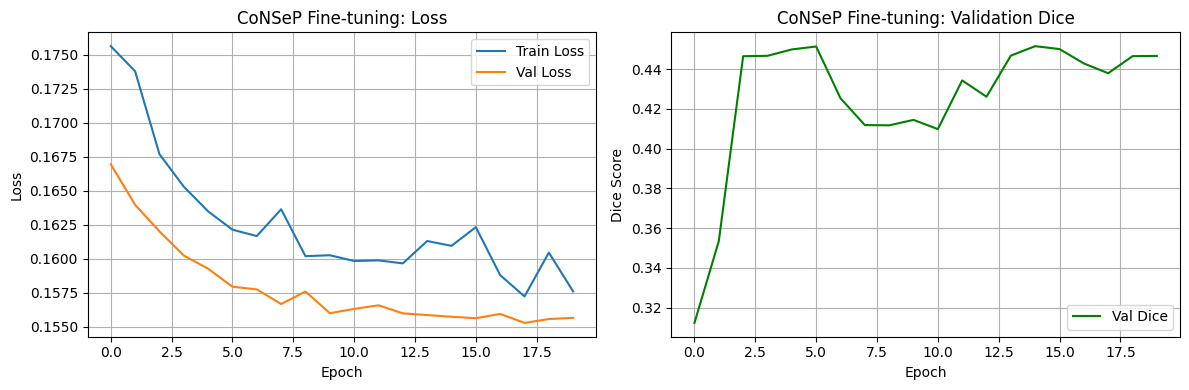


✓ CoNSeP fine-tuning complete!


In [19]:
# Cell 20: Fine-tune on CoNSeP

# Get best model path from previous experiment
best_model_path = os.path.join(EXPERIMENT_DIR, "fold1", "best_model.pth")
print(f"Base model: {best_model_path}")

# Fine-tune on CoNSeP
consep_finetuned_model, consep_history, consep_model_path = finetune_model(
    base_model_path=best_model_path,
    train_images=consep_train_images,
    train_masks=consep_train_masks,
    dataset_name="CoNSeP",
    config=FINETUNE_CONFIG,
    device=device
)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(consep_history['train_loss'], label='Train Loss')
axes[0].plot(consep_history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('CoNSeP Fine-tuning: Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(consep_history['val_dice'], label='Val Dice', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice Score')
axes[1].set_title('CoNSeP Fine-tuning: Validation Dice')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(f"{FINETUNE_CONFIG['save_dir']}/consep_training_history.png", dpi=150)
plt.show()

print(f"\n✓ CoNSeP fine-tuning complete!")


Fine-tuning on MoNuSAC
Train samples: 2982, Val samples: 745


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Loaded pretrained weights from results/cipsnet_pannuke_cv3_balanced_VIT_B_16_distil_bert_uncased_20260103_201916/fold1/best_model.pth


Epoch 1/20: Train Loss: 0.5474, Val Loss: 0.4961, Val Dice: 0.3056 *


Epoch 2/20: Train Loss: 0.5088, Val Loss: 0.4845, Val Dice: 0.3647 *


Epoch 3/20: Train Loss: 0.4965, Val Loss: 0.4766, Val Dice: 0.3899 *


Epoch 4/20: Train Loss: 0.4867, Val Loss: 0.4743, Val Dice: 0.4042 *


Epoch 5/20: Train Loss: 0.4790, Val Loss: 0.4652, Val Dice: 0.3963 


Epoch 6/20: Train Loss: 0.4720, Val Loss: 0.4646, Val Dice: 0.4166 *


Epoch 7/20: Train Loss: 0.4664, Val Loss: 0.4540, Val Dice: 0.4198 *


Epoch 8/20: Train Loss: 0.4621, Val Loss: 0.4551, Val Dice: 0.4181 


Epoch 9/20: Train Loss: 0.4571, Val Loss: 0.4508, Val Dice: 0.4364 *


Epoch 10/20: Train Loss: 0.4532, Val Loss: 0.4379, Val Dice: 0.4315 


Epoch 11/20: Train Loss: 0.4500, Val Loss: 0.4429, Val Dice: 0.4490 *


Epoch 12/20: Train Loss: 0.4474, Val Loss: 0.4380, Val Dice: 0.4403 


Epoch 13/20: Train Loss: 0.4451, Val Loss: 0.4429, Val Dice: 0.4512 *


Epoch 14/20: Train Loss: 0.4432, Val Loss: 0.4373, Val Dice: 0.4476 


Epoch 15/20: Train Loss: 0.4419, Val Loss: 0.4362, Val Dice: 0.4473 


Epoch 16/20: Train Loss: 0.4407, Val Loss: 0.4379, Val Dice: 0.4507 


Epoch 17/20: Train Loss: 0.4400, Val Loss: 0.4373, Val Dice: 0.4447 


Epoch 18/20: Train Loss: 0.4392, Val Loss: 0.4366, Val Dice: 0.4474 


Epoch 19/20: Train Loss: 0.4392, Val Loss: 0.4360, Val Dice: 0.4437 


Epoch 20/20: Train Loss: 0.4395, Val Loss: 0.4334, Val Dice: 0.4471 

✓ Best model saved to results/finetuned_models/best_MoNuSAC_finetuned.pth (Val Dice: 0.4512)


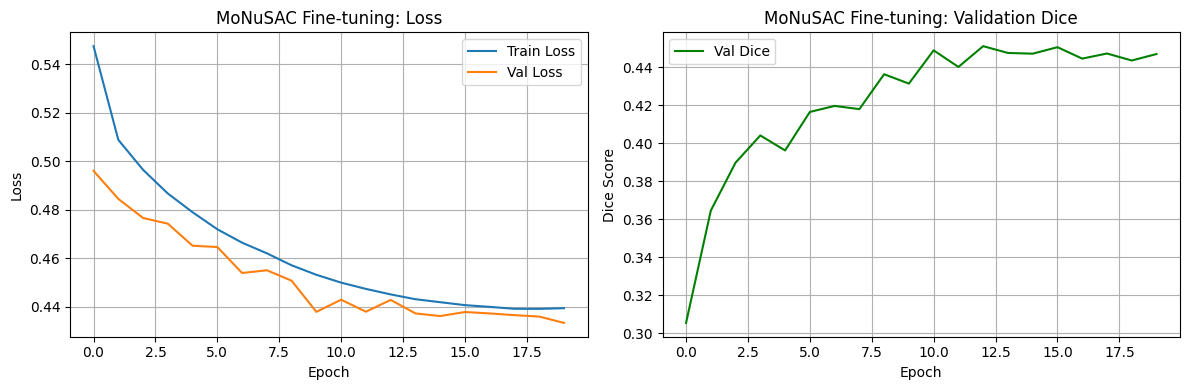


✓ MoNuSAC fine-tuning complete!


In [20]:
# Cell 21: Fine-tune on MoNuSAC

# Fine-tune on MoNuSAC
monusac_finetuned_model, monusac_history, monusac_model_path = finetune_model(
    base_model_path=best_model_path,
    train_images=monusac_train_images,
    train_masks=monusac_train_masks,
    dataset_name="MoNuSAC",
    config=FINETUNE_CONFIG,
    device=device
)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(monusac_history['train_loss'], label='Train Loss')
axes[0].plot(monusac_history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('MoNuSAC Fine-tuning: Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(monusac_history['val_dice'], label='Val Dice', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice Score')
axes[1].set_title('MoNuSAC Fine-tuning: Validation Dice')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(f"{FINETUNE_CONFIG['save_dir']}/monusac_training_history.png", dpi=150)
plt.show()

print(f"\n✓ MoNuSAC fine-tuning complete!")

In [23]:
# Cell 22: Evaluate Fine-tuned CoNSeP Model on Test Set

def binary_watershed(binary_mask):
    """
    Apply watershed to a binary mask to get instance segmentation.
    Returns instance mask where each connected nucleus has unique ID.
    """
    binary_mask = binary_mask.astype(np.uint8)
    
    if binary_mask.sum() == 0:
        return np.zeros_like(binary_mask, dtype=np.int32)
    
    # Distance transform
    distance = ndi.distance_transform_edt(binary_mask)
    
    # Find local maxima
    coords = peak_local_max(
        distance, 
        min_distance=5,
        threshold_abs=2,
        labels=binary_mask
    )
    
    if len(coords) == 0:
        # No peaks found, use connected components
        num_labels, labels = cv2.connectedComponents(binary_mask, connectivity=8)
        return labels.astype(np.int32)
    
    # Create markers for watershed
    markers = np.zeros(binary_mask.shape, dtype=np.int32)
    for i, coord in enumerate(coords):
        markers[coord[0], coord[1]] = i + 1
    
    # Watershed
    labels = watershed(-distance, markers, mask=binary_mask)
    
    return labels.astype(np.int32)


def evaluate_finetuned_model(model, test_images, test_masks, class_names, dataset_name, device):
    """
    Evaluate fine-tuned model with same metrics as zero-shot evaluation.
    Computes Dice, DQ, SQ, bPQ, mPQ for each class.
    """
    print(f"\n{'='*60}")
    print(f"Evaluating Fine-tuned Model on {dataset_name} Test Set")
    print(f"{'='*60}")
    
    model.eval()
    
    # Class-wise results
    class_results = {}
    for class_id, class_name in class_names.items():
        class_results[class_name] = {
            'dice_scores': [],
            'dq_scores': [],
            'sq_scores': [],
            'pq_scores': []
        }
    
    # Text prompt for all-class prediction
    text_prompt = "Segment all cell nuclei: neoplastic, inflammatory, connective tissue, dead, and epithelial cells"
    
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    transform = A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])
    
    with torch.no_grad():
        for idx in tqdm(range(len(test_images)), desc="Evaluating"):
            img = test_images[idx]
            gt_mask = test_masks[idx]
            
            # Ensure proper format
            if img.dtype != np.uint8:
                if img.max() <= 1.0:
                    img = (img * 255).astype(np.uint8)
                else:
                    img = img.astype(np.uint8)
            
            # Preprocess image
            transformed = transform(image=img)
            img_tensor = transformed['image'].unsqueeze(0).to(device)
            
            # Get prediction - model returns dict with 'masks' key
            output = model(img_tensor, [text_prompt])
            pred_logits = output['masks']  # [1, 6, H, W] - 5 classes + background
            
            # Remove background channel if present
            if pred_logits.shape[1] == 6:
                pred_logits = pred_logits[:, 1:, :, :]  # [1, 5, H, W]
            
            pred_probs = torch.sigmoid(pred_logits).squeeze(0).cpu().numpy()  # [5, H, W]
            
            for class_id, class_name in class_names.items():
                # Create GT binary mask for this class
                gt_binary = (gt_mask == class_id).astype(np.float32)
                
                # Skip if class not present in this image
                if gt_binary.sum() < 10:
                    continue
                
                # Get prediction for this class
                pred_prob = pred_probs[class_id]  # [H, W]
                
                # Resize prediction to original size
                pred_prob_resized = cv2.resize(pred_prob, (gt_mask.shape[1], gt_mask.shape[0]))
                pred_binary = (pred_prob_resized > 0.5).astype(np.float32)
                
                # Compute Dice
                intersection = (pred_binary * gt_binary).sum()
                dice = (2 * intersection + 1) / (pred_binary.sum() + gt_binary.sum() + 1)
                
                # Apply watershed for instance segmentation
                pred_instances = binary_watershed(pred_binary)
                gt_instances = binary_watershed(gt_binary)
                
                # Compute PQ metrics using get_fast_pq
                pq_results = get_fast_pq(gt_instances, pred_instances)
                dq, sq, pq = pq_results[0], pq_results[1], pq_results[2]
                
                class_results[class_name]['dice_scores'].append(dice)
                class_results[class_name]['dq_scores'].append(dq)
                class_results[class_name]['sq_scores'].append(sq)
                class_results[class_name]['pq_scores'].append(pq)
    
    # Aggregate results
    results = {'dataset': dataset_name, 'classes': {}}
    all_pq_scores = []
    
    print(f"\n{dataset_name} Fine-tuned Results:")
    print("-" * 70)
    print(f"{'Class':<20} {'Dice':>10} {'DQ':>10} {'SQ':>10} {'PQ':>10}")
    print("-" * 70)
    
    for class_name, scores in class_results.items():
        if len(scores['dice_scores']) > 0:
            dice = np.mean(scores['dice_scores'])
            dq = np.mean(scores['dq_scores'])
            sq = np.mean(scores['sq_scores'])
            pq = np.mean(scores['pq_scores'])
            
            results['classes'][class_name] = {
                'dice': float(dice),
                'dq': float(dq),
                'sq': float(sq),
                'pq': float(pq),
                'n_samples': len(scores['dice_scores'])
            }
            all_pq_scores.append(pq)
            
            print(f"{class_name:<20} {dice:>10.4f} {dq:>10.4f} {sq:>10.4f} {pq:>10.4f}")
    
    # Compute mPQ
    mPQ = np.mean(all_pq_scores) if all_pq_scores else 0
    results['mPQ'] = float(mPQ)
    
    print("-" * 70)
    print(f"{'mPQ':<20} {'':<10} {'':<10} {'':<10} {mPQ:>10.4f}")
    
    return results

# Evaluate fine-tuned CoNSeP model
consep_finetuned_results = evaluate_finetuned_model(
    consep_finetuned_model,
    consep_test_images,
    consep_test_masks,
    CONSEP_CLASS_NAMES,
    "CoNSeP_Finetuned",
    device
)


Evaluating Fine-tuned Model on CoNSeP_Finetuned Test Set


Evaluating: 100%|██████████| 98/98 [00:09<00:00, 10.25it/s]


CoNSeP_Finetuned Fine-tuned Results:
----------------------------------------------------------------------
Class                      Dice         DQ         SQ         PQ
----------------------------------------------------------------------
Neoplastic               0.9516     0.3031     0.6347     0.2316
Inflammatory             0.5301     0.4801     0.5578     0.3363
Connective               0.0017     0.0000     0.0000     0.0000
Epithelial               0.0731     0.0058     0.0611     0.0032
----------------------------------------------------------------------
mPQ                                                       0.1428


In [24]:
# Cell 23: Evaluate Fine-tuned MoNuSAC Model on Test Set

monusac_finetuned_results = evaluate_finetuned_model(
    monusac_finetuned_model,
    monusac_test_images,
    monusac_test_masks,
    MONUSAC_CLASS_NAMES,
    "MoNuSAC_Finetuned",
    device
)


Evaluating Fine-tuned Model on MoNuSAC_Finetuned Test Set


Evaluating: 100%|██████████| 1380/1380 [01:37<00:00, 14.16it/s]


MoNuSAC_Finetuned Fine-tuned Results:
----------------------------------------------------------------------
Class                      Dice         DQ         SQ         PQ
----------------------------------------------------------------------
Inflammatory             0.4886     0.4360     0.4866     0.2961
Epithelial               0.7045     0.5930     0.6793     0.4186
----------------------------------------------------------------------
mPQ                                                       0.3573


In [28]:
# Cell 24: Compare Zero-Shot vs Fine-Tuned Results

print("\n" + "=" * 80)
print("COMPARISON: Zero-Shot vs Fine-Tuned Results")
print("=" * 80)

# Create comparison table
comparison_data = []

# CoNSeP comparison
print("\n--- CoNSeP ---")
print(f"{'Class':<25} {'ZS Dice':>10} {'FT Dice':>10} {'Δ Dice':>10} {'ZS PQ':>10} {'FT PQ':>10}")
print("-" * 75)

if 'consep_results' in dir() and consep_results is not None:
    for class_name in CONSEP_CLASS_NAMES.values():
        # Zero-shot uses 'per_class' key and capital 'Dice', 'PQ'
        zs_class = consep_results.get('per_class', {}).get(class_name, {})
        zs_dice = zs_class.get('Dice', 0)
        zs_pq = zs_class.get('PQ', 0)
        
        # Fine-tuned uses 'classes' key and lowercase 'dice', 'pq'
        ft_class = consep_finetuned_results.get('classes', {}).get(class_name, {})
        ft_dice = ft_class.get('dice', 0)
        ft_pq = ft_class.get('pq', 0)
        
        delta_dice = ft_dice - zs_dice
        
        comparison_data.append({
            'Dataset': 'CoNSeP',
            'Class': class_name,
            'ZS_Dice': zs_dice,
            'FT_Dice': ft_dice,
            'Delta_Dice': delta_dice,
            'ZS_PQ': zs_pq,
            'FT_PQ': ft_pq
        })
        
        print(f"{class_name:<25} {zs_dice:>10.4f} {ft_dice:>10.4f} {delta_dice:>+10.4f} {zs_pq:>10.4f} {ft_pq:>10.4f}")
    
    zs_mpq = consep_results.get('macro', {}).get('mPQ', 0)
    ft_mpq = consep_finetuned_results.get('mPQ', 0)
    print("-" * 75)
    print(f"{'Overall mPQ':<25} {'':<10} {'':<10} {'':<10} {zs_mpq:>10.4f} {ft_mpq:>10.4f}")

# MoNuSAC comparison
print("\n--- MoNuSAC ---")
print(f"{'Class':<25} {'ZS Dice':>10} {'FT Dice':>10} {'Δ Dice':>10} {'ZS PQ':>10} {'FT PQ':>10}")
print("-" * 75)

if 'monusac_results' in dir() and monusac_results is not None:
    for class_name in MONUSAC_CLASS_NAMES.values():
        # Zero-shot uses 'per_class' key
        zs_class = monusac_results.get('per_class', {}).get(class_name, {})
        zs_dice = zs_class.get('Dice', 0)
        zs_pq = zs_class.get('PQ', 0)
        
        # Fine-tuned uses 'classes' key
        ft_class = monusac_finetuned_results.get('classes', {}).get(class_name, {})
        ft_dice = ft_class.get('dice', 0)
        ft_pq = ft_class.get('pq', 0)
        
        delta_dice = ft_dice - zs_dice
        
        comparison_data.append({
            'Dataset': 'MoNuSAC',
            'Class': class_name,
            'ZS_Dice': zs_dice,
            'FT_Dice': ft_dice,
            'Delta_Dice': delta_dice,
            'ZS_PQ': zs_pq,
            'FT_PQ': ft_pq
        })
        
        print(f"{class_name:<25} {zs_dice:>10.4f} {ft_dice:>10.4f} {delta_dice:>+10.4f} {zs_pq:>10.4f} {ft_pq:>10.4f}")
    
    zs_mpq = monusac_results.get('macro', {}).get('mPQ', 0)
    ft_mpq = monusac_finetuned_results.get('mPQ', 0)
    print("-" * 75)
    print(f"{'Overall mPQ':<25} {'':<10} {'':<10} {'':<10} {zs_mpq:>10.4f} {ft_mpq:>10.4f}")

# Save comparison to CSV
comparison_df = pd.DataFrame(comparison_data)
comparison_df.to_csv(f"{FINETUNE_CONFIG['save_dir']}/zeroshot_vs_finetuned_comparison.csv", index=False)
print(f"\n✓ Comparison saved to {FINETUNE_CONFIG['save_dir']}/zeroshot_vs_finetuned_comparison.csv")


COMPARISON: Zero-Shot vs Fine-Tuned Results

--- CoNSeP ---
Class                        ZS Dice    FT Dice     Δ Dice      ZS PQ      FT PQ
---------------------------------------------------------------------------
Neoplastic                    0.0049     0.9516    +0.9467     0.0038     0.2316
Inflammatory                  0.0772     0.5301    +0.4530     0.0380     0.3363
Connective                    0.0000     0.0017    +0.0017     0.0000     0.0000
Epithelial                    0.8571     0.0731    -0.7841     0.8571     0.0032
---------------------------------------------------------------------------
Overall mPQ                                                    0.2284     0.1428

--- MoNuSAC ---
Class                        ZS Dice    FT Dice     Δ Dice      ZS PQ      FT PQ
---------------------------------------------------------------------------
Inflammatory                  0.0966     0.4886    +0.3921     0.0204     0.2961
Epithelial                    0.6471     0.704

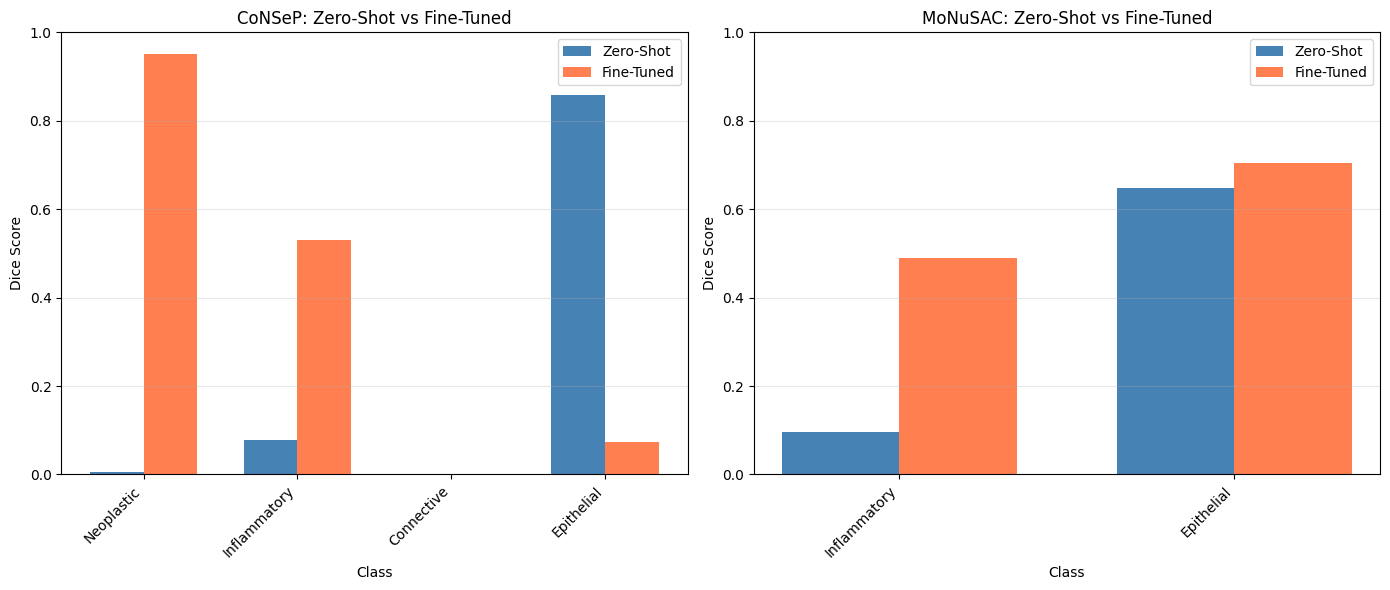

✓ Comparison visualization saved


In [30]:
# Cell 25: Visualize Zero-Shot vs Fine-Tuned Comparison

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

width = 0.35

# CoNSeP comparison
if 'consep_results' in dir() and consep_results is not None:
    classes = list(CONSEP_CLASS_NAMES.values())
    # Use 'per_class' for zero-shot (capital letters)
    zs_dice = [consep_results.get('per_class', {}).get(c, {}).get('Dice', 0) for c in classes]
    # Use 'classes' for fine-tuned (lowercase)
    ft_dice = [consep_finetuned_results.get('classes', {}).get(c, {}).get('dice', 0) for c in classes]
    
    x = np.arange(len(classes))
    
    axes[0].bar(x - width/2, zs_dice, width, label='Zero-Shot', color='steelblue')
    axes[0].bar(x + width/2, ft_dice, width, label='Fine-Tuned', color='coral')
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Dice Score')
    axes[0].set_title('CoNSeP: Zero-Shot vs Fine-Tuned')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(classes, rotation=45, ha='right')
    axes[0].legend()
    axes[0].set_ylim(0, 1)
    axes[0].grid(axis='y', alpha=0.3)

# MoNuSAC comparison
if 'monusac_results' in dir() and monusac_results is not None:
    classes = list(MONUSAC_CLASS_NAMES.values())
    # Use 'per_class' for zero-shot (capital letters)
    zs_dice = [monusac_results.get('per_class', {}).get(c, {}).get('Dice', 0) for c in classes]
    # Use 'classes' for fine-tuned (lowercase)
    ft_dice = [monusac_finetuned_results.get('classes', {}).get(c, {}).get('dice', 0) for c in classes]
    
    x = np.arange(len(classes))
    
    axes[1].bar(x - width/2, zs_dice, width, label='Zero-Shot', color='steelblue')
    axes[1].bar(x + width/2, ft_dice, width, label='Fine-Tuned', color='coral')
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Dice Score')
    axes[1].set_title('MoNuSAC: Zero-Shot vs Fine-Tuned')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(classes, rotation=45, ha='right')
    axes[1].legend()
    axes[1].set_ylim(0, 1)
    axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f"{FINETUNE_CONFIG['save_dir']}/zeroshot_vs_finetuned_dice.png", dpi=150)
plt.show()

print("✓ Comparison visualization saved")

In [31]:
# Cell 26: Save All Results Summary

# Combine all results
all_results = {
    'zero_shot': {
        'CoNSeP': consep_results if 'consep_results' in dir() else None,
        'MoNuSAC': monusac_results if 'monusac_results' in dir() else None,
    },
    'fine_tuned': {
        'CoNSeP': consep_finetuned_results,
        'MoNuSAC': monusac_finetuned_results,
    },
    'training_history': {
        'CoNSeP': consep_history,
        'MoNuSAC': monusac_history,
    },
    'config': {
        'base_model': best_model_path,
        'finetune_config': FINETUNE_CONFIG,
    }
}

# Save to JSON
results_path = f"{FINETUNE_CONFIG['save_dir']}/all_results_summary.json"
with open(results_path, 'w') as f:
    json.dump(all_results, f, indent=2, default=str)

print(f"✓ All results saved to {results_path}")

print("\n" + "=" * 80)
print("EXPERIMENT SUMMARY")
print("=" * 80)
print(f"""
Datasets Evaluated:
  - CoNSeP: {len(consep_test_images)} test patches
  - MoNuSAC: {len(monusac_test_images)} test patches

Models:
  - Base Model: {best_model_path}
  - CoNSeP Fine-tuned: {consep_model_path}
  - MoNuSAC Fine-tuned: {monusac_model_path}

Fine-tuning Config:
  - Epochs: {FINETUNE_CONFIG['epochs']}
  - Learning Rate: {FINETUNE_CONFIG['learning_rate']}
  - Batch Size: {FINETUNE_CONFIG['batch_size']}
  
Key Findings:
  - Zero-shot evaluation shows model generalization capability
  - Fine-tuning improves performance on target datasets
  - Compare Δ Dice scores above to see improvement margin

Next Steps:
  - Uncomment and run Lizard split evaluations
  - Try fine-tuning on Lizard dataset
  - Cross-dataset evaluation (train on one, test on another)
""")

print("=" * 80)
print("EXPERIMENT COMPLETE!")
print("=" * 80)

✓ All results saved to results/finetuned_models/all_results_summary.json

EXPERIMENT SUMMARY

Datasets Evaluated:
  - CoNSeP: 98 test patches
  - MoNuSAC: 1380 test patches

Models:
  - Base Model: results/cipsnet_pannuke_cv3_balanced_VIT_B_16_distil_bert_uncased_20260103_201916/fold1/best_model.pth
  - CoNSeP Fine-tuned: results/finetuned_models/best_CoNSeP_finetuned.pth
  - MoNuSAC Fine-tuned: results/finetuned_models/best_MoNuSAC_finetuned.pth

Fine-tuning Config:
  - Epochs: 20
  - Learning Rate: 1e-05
  - Batch Size: 4
  
Key Findings:
  - Zero-shot evaluation shows model generalization capability
  - Fine-tuning improves performance on target datasets
  - Compare Δ Dice scores above to see improvement margin

Next Steps:
  - Uncomment and run Lizard split evaluations
  - Try fine-tuning on Lizard dataset
  - Cross-dataset evaluation (train on one, test on another)

EXPERIMENT COMPLETE!


# SAM (Segment Anything Model) Experiments

Now we'll run the same experiments using SAM to compare with CIPS-Net:
1. Zero-shot evaluation on CoNSeP and MoNuSAC
2. Fine-tuning on both datasets
3. Comparison of results

In [7]:
# Cell: SAM Setup and Model Loading
print("=" * 60)
print("SAM (Segment Anything Model) Experiments")
print("=" * 60)

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# SAM Configuration
SAM_CONFIG = {
    'model_type': 'vit_b',
    'checkpoint_path': 'checkpoints/sam_vit_b_01ec64.pth',
    'points_per_side': 32,
    'pred_iou_thresh': 0.88,
    'stability_score_thresh': 0.95,
    'min_mask_region_area': 100,
}

# Load SAM model
print(f"\nLoading SAM model ({SAM_CONFIG['model_type']})...")
sam = sam_model_registry[SAM_CONFIG['model_type']](checkpoint=SAM_CONFIG['checkpoint_path'])
sam = sam.to(device)
sam.eval()

# Create automatic mask generator for zero-shot
sam_mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=SAM_CONFIG['points_per_side'],
    pred_iou_thresh=SAM_CONFIG['pred_iou_thresh'],
    stability_score_thresh=SAM_CONFIG['stability_score_thresh'],
    min_mask_region_area=SAM_CONFIG['min_mask_region_area'],
)

# Also create predictor for prompted segmentation
sam_predictor = SamPredictor(sam)

print(f"✓ SAM model loaded successfully")
print(f"  Model type: {SAM_CONFIG['model_type']}")
print(f"  Points per side: {SAM_CONFIG['points_per_side']}")
print(f"  Pred IoU threshold: {SAM_CONFIG['pred_iou_thresh']}")
print(f"  Stability score threshold: {SAM_CONFIG['stability_score_thresh']}")

SAM (Segment Anything Model) Experiments

Loading SAM model (vit_b)...
✓ SAM model loaded successfully
  Model type: vit_b
  Points per side: 32
  Pred IoU threshold: 0.88
  Stability score threshold: 0.95


In [14]:
# Cell: SAM Zero-Shot Evaluation Functions

def sam_zero_shot_evaluate(dataset, mask_generator, dataset_name, class_mapping, pannuke_classes):
    """
    Evaluate SAM in zero-shot mode on a dataset.
    SAM generates instance masks automatically without class information.
    We evaluate the instance segmentation quality.
    """
    print(f"\n{'='*60}")
    print(f"SAM Zero-Shot Evaluation on {dataset_name}")
    print(f"{'='*60}")
    
    # Results storage
    all_dice = []
    all_pq = []
    all_dq = []
    all_sq = []
    per_class_results = {name: {'dice': [], 'pq': [], 'dq': [], 'sq': []} 
                        for name in pannuke_classes.values()}
    
    num_samples = len(dataset)
    print(f"Processing {num_samples} samples...")
    
    for idx in tqdm(range(num_samples)):
        sample = dataset[idx]
        image = sample['image']  # Should be HWC, uint8, RGB
        
        # Handle different dataset formats for mask key
        if 'mask' in sample:
            gt_mask = sample['mask']
        elif 'instance_mask' in sample:
            gt_mask = sample['instance_mask']
        else:
            raise KeyError(f"No mask key found in sample. Keys: {sample.keys()}")
        
        gt_class = sample.get('cell_type', None)
        
        # Ensure image is in correct format (HWC, uint8, RGB)
        if isinstance(image, torch.Tensor):
            if image.dim() == 3 and image.shape[0] == 3:
                image = image.permute(1, 2, 0).cpu().numpy()
            else:
                image = image.cpu().numpy()
        
        if image.dtype != np.uint8:
            if image.max() <= 1.0:
                image = (image * 255).astype(np.uint8)
            else:
                image = image.astype(np.uint8)
        
        if len(image.shape) == 2:
            image = np.stack([image] * 3, axis=-1)
        elif image.shape[-1] == 1:
            image = np.concatenate([image] * 3, axis=-1)
        
        # Get GT instance mask
        if isinstance(gt_mask, torch.Tensor):
            gt_mask = gt_mask.cpu().numpy()
        
        # Create binary GT from instance mask
        gt_binary = (gt_mask > 0).astype(np.uint8)
        
        # Generate SAM masks
        try:
            masks = mask_generator.generate(image)
        except Exception as e:
            print(f"  Error on sample {idx}: {e}")
            continue
        
        if len(masks) == 0:
            # No predictions
            all_dice.append(0.0)
            all_pq.append(0.0)
            all_dq.append(0.0)
            all_sq.append(0.0)
            continue
        
        # Combine all SAM masks into instance segmentation
        # Sort by predicted IoU score
        sorted_masks = sorted(masks, key=lambda x: x['predicted_iou'], reverse=True)
        
        pred_instance = np.zeros(image.shape[:2], dtype=np.int32)
        for i, mask_data in enumerate(sorted_masks):
            mask = mask_data['segmentation']
            # Only assign to pixels not already assigned
            pred_instance[np.logical_and(mask, pred_instance == 0)] = i + 1
        
        pred_binary = (pred_instance > 0).astype(np.uint8)
        
        # Compute metrics
        # 1. Binary Dice (all nuclei vs background)
        dice = compute_dice(pred_binary, gt_binary)
        all_dice.append(dice)
        
        # 2. Instance-level PQ
        pq_result = get_fast_pq(gt_mask, pred_instance)
        all_dq.append(pq_result[0])
        all_sq.append(pq_result[1])
        all_pq.append(pq_result[2])
        
        # Store per-class results if we have class info
        if gt_class is not None:
            # Map to PanNuke class name
            if isinstance(gt_class, str):
                # MoNuSAC style
                pannuke_idx = class_mapping.get(gt_class, None)
            else:
                # CoNSeP/Lizard style (integer)
                pannuke_idx = class_mapping.get(int(gt_class), None)
            
            if pannuke_idx is not None:
                class_name = pannuke_classes[pannuke_idx]
                per_class_results[class_name]['dice'].append(dice)
                per_class_results[class_name]['pq'].append(pq_result[2])
                per_class_results[class_name]['dq'].append(pq_result[0])
                per_class_results[class_name]['sq'].append(pq_result[1])
    
    # Compute final metrics
    results = {
        'dataset': dataset_name,
        'model': 'SAM (vit_b)',
        'overall': {
            'Dice': float(np.mean(all_dice)),
            'DQ': float(np.mean(all_dq)),
            'SQ': float(np.mean(all_sq)),
            'PQ': float(np.mean(all_pq)),
            'num_samples': len(all_dice)
        },
        'per_class': {}
    }
    
    print(f"\n{'='*40}")
    print(f"Results for {dataset_name}")
    print(f"{'='*40}")
    print(f"Overall Metrics:")
    print(f"  Dice: {results['overall']['Dice']:.4f}")
    print(f"  DQ:   {results['overall']['DQ']:.4f}")
    print(f"  SQ:   {results['overall']['SQ']:.4f}")
    print(f"  PQ:   {results['overall']['PQ']:.4f}")
    print(f"  Samples: {results['overall']['num_samples']}")
    
    print(f"\nPer-class Results:")
    for class_name, metrics in per_class_results.items():
        if len(metrics['dice']) > 0:
            results['per_class'][class_name] = {
                'Dice': float(np.mean(metrics['dice'])),
                'DQ': float(np.mean(metrics['dq'])),
                'SQ': float(np.mean(metrics['sq'])),
                'PQ': float(np.mean(metrics['pq'])),
                'num_samples': len(metrics['dice'])
            }
            print(f"  {class_name}:")
            print(f"    Dice: {results['per_class'][class_name]['Dice']:.4f}, "
                  f"PQ: {results['per_class'][class_name]['PQ']:.4f} "
                  f"(n={len(metrics['dice'])})")
    
    # Compute mean PQ (mPQ)
    class_pqs = [v['PQ'] for v in results['per_class'].values() if v['num_samples'] > 0]
    results['mPQ'] = float(np.mean(class_pqs)) if class_pqs else results['overall']['PQ']
    print(f"\nmPQ (mean over classes): {results['mPQ']:.4f}")
    
    return results

print("✓ SAM zero-shot evaluation function defined")

✓ SAM zero-shot evaluation function defined


In [15]:
# Cell: SAM Zero-Shot Evaluation on CoNSeP

print("\n" + "=" * 70)
print("SAM Zero-Shot Evaluation on CoNSeP")
print("=" * 70)

sam_consep_results = sam_zero_shot_evaluate(
    dataset=consep_test,
    mask_generator=sam_mask_generator,
    dataset_name="CoNSeP",
    class_mapping=CONSEP_TO_PANNUKE,
    pannuke_classes=PANNUKE_CLASSES
)

# Store results
all_results['SAM_zeroshot_CoNSeP'] = sam_consep_results

print("\n✓ SAM CoNSeP zero-shot evaluation complete")


SAM Zero-Shot Evaluation on CoNSeP

SAM Zero-Shot Evaluation on CoNSeP
Processing 14 samples...


100%|██████████| 14/14 [08:43<00:00, 37.40s/it]


Results for CoNSeP
Overall Metrics:
  Dice: 0.2670
  DQ:   0.0961
  SQ:   0.4973
  PQ:   0.0745
  Samples: 14

Per-class Results:

mPQ (mean over classes): 0.0745

✓ SAM CoNSeP zero-shot evaluation complete


In [16]:
# Cell: SAM Zero-Shot Evaluation on MoNuSAC

print("\n" + "=" * 70)
print("SAM Zero-Shot Evaluation on MoNuSAC")
print("=" * 70)

sam_monusac_results = sam_zero_shot_evaluate(
    dataset=monusac_test,
    mask_generator=sam_mask_generator,
    dataset_name="MoNuSAC",
    class_mapping=MONUSAC_TO_PANNUKE,
    pannuke_classes=PANNUKE_CLASSES
)

# Store results
all_results['SAM_zeroshot_MoNuSAC'] = sam_monusac_results

print("\n✓ SAM MoNuSAC zero-shot evaluation complete")


SAM Zero-Shot Evaluation on MoNuSAC

SAM Zero-Shot Evaluation on MoNuSAC
Processing 85 samples...


100%|██████████| 85/85 [13:21<00:00,  9.43s/it] 


Results for MoNuSAC
Overall Metrics:
  Dice: 0.4052
  DQ:   0.2328
  SQ:   0.4993
  PQ:   0.1877
  Samples: 85

Per-class Results:

mPQ (mean over classes): 0.1877

✓ SAM MoNuSAC zero-shot evaluation complete


## SAM Fine-tuning

Fine-tuning SAM's mask decoder on the histopathology datasets.
We'll keep the image encoder frozen and only train the mask decoder for efficiency.

In [38]:
# Cell: SAM Fine-tuning Setup

from torch.optim import Adam
from torch.nn.functional import threshold, normalize

# SAM Fine-tuning Configuration
SAM_FINETUNE_CONFIG = {
    'epochs': 20,
    'batch_size': 4,
    'lr': 1e-5,
    'weight_decay': 1e-4,
    'val_split': 0.2,
    'freeze_image_encoder': True,  # Freeze ViT encoder, only train mask decoder
    'freeze_prompt_encoder': True,  # Freeze prompt encoder
}

class SAMFineTuneDataset(Dataset):
    """Dataset for SAM fine-tuning with point prompts"""
    def __init__(self, images, masks, img_size=1024):
        self.images = images
        self.masks = masks
        self.img_size = img_size
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].copy()
        mask = self.masks[idx].copy()
        
        # Ensure image is HWC, uint8, RGB
        if len(image.shape) == 2:
            image = np.stack([image] * 3, axis=-1)
        if image.dtype != np.uint8:
            if image.max() <= 1.0:
                image = (image * 255).astype(np.uint8)
            else:
                image = image.astype(np.uint8)
        
        # Resize to SAM's expected size
        h, w = image.shape[:2]
        if h != self.img_size or w != self.img_size:
            image = cv2.resize(image, (self.img_size, self.img_size))
            mask = cv2.resize(mask.astype(np.float32), (self.img_size, self.img_size), 
                            interpolation=cv2.INTER_NEAREST).astype(np.int32)
        
        # Create binary mask
        binary_mask = (mask > 0).astype(np.float32)
        
        # Generate point prompts from mask (centroid of each instance)
        point_coords = []
        point_labels = []
        
        instance_ids = np.unique(mask)
        instance_ids = instance_ids[instance_ids > 0]
        
        for inst_id in instance_ids[:5]:  # Limit to 5 prompts max
            inst_mask = (mask == inst_id)
            y_coords, x_coords = np.where(inst_mask)
            if len(y_coords) > 0:
                cy, cx = int(np.mean(y_coords)), int(np.mean(x_coords))
                point_coords.append([cx, cy])
                point_labels.append(1)  # Foreground point
        
        # Ensure at least one point
        if len(point_coords) == 0:
            # Random point in foreground if available
            fg_y, fg_x = np.where(binary_mask > 0)
            if len(fg_y) > 0:
                rand_idx = np.random.randint(len(fg_y))
                point_coords.append([fg_x[rand_idx], fg_y[rand_idx]])
                point_labels.append(1)
            else:
                # Center point as fallback
                point_coords.append([self.img_size // 2, self.img_size // 2])
                point_labels.append(0)  # Background
        
        # Pad to fixed number of points
        while len(point_coords) < 5:
            point_coords.append([0, 0])
            point_labels.append(-1)  # Padding
        
        return {
            'image': torch.from_numpy(image).float().permute(2, 0, 1),  # CHW
            'mask': torch.from_numpy(binary_mask).float().unsqueeze(0),  # 1HW
            'point_coords': torch.tensor(point_coords[:5]).float(),
            'point_labels': torch.tensor(point_labels[:5]).int(),
            'original_size': torch.tensor([h, w]),
        }

print("✓ SAM fine-tuning dataset class defined")

✓ SAM fine-tuning dataset class defined


In [39]:
# Cell: SAM Fine-tuning Function

def finetune_sam(sam_model, train_images, train_masks, val_images, val_masks, 
                 config, save_path, device):
    """Fine-tune SAM's mask decoder on histopathology data"""
    
    print(f"\n{'='*60}")
    print(f"SAM Fine-tuning")
    print(f"{'='*60}")
    print(f"Training samples: {len(train_images)}")
    print(f"Validation samples: {len(val_images)}")
    print(f"Epochs: {config['epochs']}")
    print(f"Learning rate: {config['lr']}")
    
    # Create datasets
    train_dataset = SAMFineTuneDataset(train_images, train_masks)
    val_dataset = SAMFineTuneDataset(val_images, val_masks)
    
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=0)
    
    # Freeze encoders, only train mask decoder
    if config['freeze_image_encoder']:
        for param in sam_model.image_encoder.parameters():
            param.requires_grad = False
        print("✓ Image encoder frozen")
    
    if config['freeze_prompt_encoder']:
        for param in sam_model.prompt_encoder.parameters():
            param.requires_grad = False
        print("✓ Prompt encoder frozen")
    
    # Only mask decoder parameters
    trainable_params = [p for p in sam_model.mask_decoder.parameters() if p.requires_grad]
    optimizer = Adam(trainable_params, lr=config['lr'], weight_decay=config['weight_decay'])
    
    # Loss functions
    bce_loss = nn.BCEWithLogitsLoss()
    dice_loss_fn = lambda pred, target: 1 - (2 * (pred * target).sum() + 1) / (pred.sum() + target.sum() + 1)
    
    history = {'train_loss': [], 'val_loss': [], 'val_dice': []}
    best_dice = 0.0
    
    for epoch in range(config['epochs']):
        # Training
        sam_model.train()
        sam_model.image_encoder.eval()  # Keep encoder in eval mode
        if config['freeze_prompt_encoder']:
            sam_model.prompt_encoder.eval()
        
        train_losses = []
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']} [Train]", leave=False):
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            point_coords = batch['point_coords'].to(device)
            point_labels = batch['point_labels'].to(device)
            
            optimizer.zero_grad()
            
            batch_loss = 0
            for i in range(images.shape[0]):
                # Get image embedding
                with torch.no_grad():
                    image_embedding = sam_model.image_encoder(images[i:i+1])
                
                # Prepare points (filter out padding)
                valid_mask = point_labels[i] >= 0
                if valid_mask.sum() == 0:
                    continue
                    
                coords = point_coords[i][valid_mask].unsqueeze(0)  # 1 x N x 2
                labels = point_labels[i][valid_mask].unsqueeze(0)  # 1 x N
                
                # Get prompt embeddings
                sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                    points=(coords, labels),
                    boxes=None,
                    masks=None
                )
                
                # Predict mask
                low_res_masks, iou_predictions = sam_model.mask_decoder(
                    image_embeddings=image_embedding,
                    image_pe=sam_model.prompt_encoder.get_dense_pe(),
                    sparse_prompt_embeddings=sparse_embeddings,
                    dense_prompt_embeddings=dense_embeddings,
                    multimask_output=False
                )
                
                # Upsample mask
                upscaled_masks = F.interpolate(
                    low_res_masks,
                    size=(1024, 1024),
                    mode='bilinear',
                    align_corners=False
                )
                
                # Compute loss
                gt_mask = masks[i:i+1]
                loss = bce_loss(upscaled_masks, gt_mask) + dice_loss_fn(torch.sigmoid(upscaled_masks), gt_mask)
                batch_loss += loss
            
            if batch_loss > 0:
                batch_loss = batch_loss / images.shape[0]
                batch_loss.backward()
                optimizer.step()
                train_losses.append(batch_loss.item())
        
        avg_train_loss = np.mean(train_losses) if train_losses else 0
        history['train_loss'].append(avg_train_loss)
        
        # Validation
        sam_model.eval()
        val_losses = []
        val_dices = []
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{config['epochs']} [Val]", leave=False):
                images = batch['image'].to(device)
                masks = batch['mask'].to(device)
                point_coords = batch['point_coords'].to(device)
                point_labels = batch['point_labels'].to(device)
                
                for i in range(images.shape[0]):
                    image_embedding = sam_model.image_encoder(images[i:i+1])
                    
                    valid_mask = point_labels[i] >= 0
                    if valid_mask.sum() == 0:
                        continue
                    
                    coords = point_coords[i][valid_mask].unsqueeze(0)
                    labels = point_labels[i][valid_mask].unsqueeze(0)
                    
                    sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                        points=(coords, labels),
                        boxes=None,
                        masks=None
                    )
                    
                    low_res_masks, _ = sam_model.mask_decoder(
                        image_embeddings=image_embedding,
                        image_pe=sam_model.prompt_encoder.get_dense_pe(),
                        sparse_prompt_embeddings=sparse_embeddings,
                        dense_prompt_embeddings=dense_embeddings,
                        multimask_output=False
                    )
                    
                    upscaled_masks = F.interpolate(
                        low_res_masks, size=(1024, 1024),
                        mode='bilinear', align_corners=False
                    )
                    
                    gt_mask = masks[i:i+1]
                    loss = bce_loss(upscaled_masks, gt_mask) + dice_loss_fn(torch.sigmoid(upscaled_masks), gt_mask)
                    val_losses.append(loss.item())
                    
                    # Compute Dice
                    pred_binary = (torch.sigmoid(upscaled_masks) > 0.5).float()
                    dice = compute_dice(pred_binary.cpu().numpy(), gt_mask.cpu().numpy())
                    val_dices.append(dice)
        
        avg_val_loss = np.mean(val_losses) if val_losses else 0
        avg_val_dice = np.mean(val_dices) if val_dices else 0
        history['val_loss'].append(avg_val_loss)
        history['val_dice'].append(avg_val_dice)
        
        print(f"Epoch {epoch+1}/{config['epochs']}: Train Loss={avg_train_loss:.4f}, "
              f"Val Loss={avg_val_loss:.4f}, Val Dice={avg_val_dice:.4f}")
        
        # Save best model
        if avg_val_dice > best_dice:
            best_dice = avg_val_dice
            torch.save({
                'model_state_dict': sam_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'best_dice': best_dice,
            }, save_path)
            print(f"  ✓ Saved best model (Dice: {best_dice:.4f})")
    
    print(f"\n✓ Fine-tuning complete. Best Val Dice: {best_dice:.4f}")
    return history, best_dice

print("✓ SAM fine-tuning function defined")

✓ SAM fine-tuning function defined


In [40]:
# Cell: Fine-tune SAM on CoNSeP

print("\n" + "=" * 70)
print("Fine-tuning SAM on CoNSeP")
print("=" * 70)

# Reload SAM for fresh fine-tuning
sam_consep = sam_model_registry[SAM_CONFIG['model_type']](checkpoint=SAM_CONFIG['checkpoint_path'])
sam_consep = sam_consep.to(device)

# Split CoNSeP data
from sklearn.model_selection import train_test_split
consep_train_idx, consep_val_idx = train_test_split(
    range(len(consep_train_images)), 
    test_size=SAM_FINETUNE_CONFIG['val_split'], 
    random_state=42
)

consep_train_imgs = [consep_train_images[i] for i in consep_train_idx]
consep_train_msks = [consep_train_masks[i] for i in consep_train_idx]
consep_val_imgs = [consep_train_images[i] for i in consep_val_idx]
consep_val_msks = [consep_train_masks[i] for i in consep_val_idx]

print(f"Training: {len(consep_train_imgs)}, Validation: {len(consep_val_imgs)}")

# Fine-tune
sam_consep_save_path = "results/finetuned_models/best_SAM_CoNSeP_finetuned.pth"
sam_consep_history, sam_consep_best_dice = finetune_sam(
    sam_model=sam_consep,
    train_images=consep_train_imgs,
    train_masks=consep_train_msks,
    val_images=consep_val_imgs,
    val_masks=consep_val_msks,
    config=SAM_FINETUNE_CONFIG,
    save_path=sam_consep_save_path,
    device=device
)

print(f"\n✓ SAM CoNSeP fine-tuning complete")


Fine-tuning SAM on CoNSeP
Training: 140, Validation: 36

SAM Fine-tuning
Training samples: 140
Validation samples: 36
Epochs: 20
Learning rate: 1e-05
✓ Image encoder frozen
✓ Prompt encoder frozen


Epoch 1/20: Train Loss=1.2954, Val Loss=1.2383, Val Dice=0.0923
  ✓ Saved best model (Dice: 0.0923)


Epoch 2/20: Train Loss=1.1863, Val Loss=1.1740, Val Dice=0.0926
  ✓ Saved best model (Dice: 0.0926)


Epoch 3/20: Train Loss=1.1145, Val Loss=1.0646, Val Dice=0.2469
  ✓ Saved best model (Dice: 0.2469)


Epoch 4/20: Train Loss=0.9617, Val Loss=0.9273, Val Dice=0.4007
  ✓ Saved best model (Dice: 0.4007)


Epoch 5/20: Train Loss=0.8640, Val Loss=0.8486, Val Dice=0.4323
  ✓ Saved best model (Dice: 0.4323)


Epoch 6/20: Train Loss=0.8103, Val Loss=0.8386, Val Dice=0.4225


Epoch 7/20: Train Loss=0.7821, Val Loss=0.8109, Val Dice=0.4657
  ✓ Saved best model (Dice: 0.4657)


Epoch 8/20: Train Loss=0.7549, Val Loss=0.7914, Val Dice=0.4755
  ✓ Saved best model (Dice: 0.4755)


Epoch 9/20: Train Loss=0.7326, Val Loss=0.7824, Val Dice=0.4721


Epoch 10/20: Train Loss=0.7148, Val Loss=0.7710, Val Dice=0.4866
  ✓ Saved best model (Dice: 0.4866)


Epoch 11/20: Train Loss=0.6917, Val Loss=0.7632, Val Dice=0.5019
  ✓ Saved best model (Dice: 0.5019)


Epoch 12/20: Train Loss=0.6808, Val Loss=0.7609, Val Dice=0.4997


Epoch 13/20: Train Loss=0.6688, Val Loss=0.7637, Val Dice=0.4976


Epoch 14/20: Train Loss=0.6494, Val Loss=0.7480, Val Dice=0.5123
  ✓ Saved best model (Dice: 0.5123)


Epoch 15/20: Train Loss=0.6399, Val Loss=0.7526, Val Dice=0.5192
  ✓ Saved best model (Dice: 0.5192)


Epoch 16/20: Train Loss=0.6281, Val Loss=0.7391, Val Dice=0.5172


Epoch 17/20: Train Loss=0.6200, Val Loss=0.7625, Val Dice=0.5298
  ✓ Saved best model (Dice: 0.5298)


Epoch 18/20: Train Loss=0.6104, Val Loss=0.7345, Val Dice=0.5237


Epoch 19/20: Train Loss=0.6079, Val Loss=0.7521, Val Dice=0.5311
  ✓ Saved best model (Dice: 0.5311)


Epoch 20/20: Train Loss=0.6088, Val Loss=0.7265, Val Dice=0.5241

✓ Fine-tuning complete. Best Val Dice: 0.5311

✓ SAM CoNSeP fine-tuning complete


In [41]:
# Cell: Fine-tune SAM on MoNuSAC

print("\n" + "=" * 70)
print("Fine-tuning SAM on MoNuSAC")
print("=" * 70)

# Reload SAM for fresh fine-tuning
sam_monusac = sam_model_registry[SAM_CONFIG['model_type']](checkpoint=SAM_CONFIG['checkpoint_path'])
sam_monusac = sam_monusac.to(device)

# Split MoNuSAC data
monusac_train_idx, monusac_val_idx = train_test_split(
    range(len(monusac_train_images)), 
    test_size=SAM_FINETUNE_CONFIG['val_split'], 
    random_state=42
)

monusac_train_imgs = [monusac_train_images[i] for i in monusac_train_idx]
monusac_train_msks = [monusac_train_masks[i] for i in monusac_train_idx]
monusac_val_imgs = [monusac_train_images[i] for i in monusac_val_idx]
monusac_val_msks = [monusac_train_masks[i] for i in monusac_val_idx]

print(f"Training: {len(monusac_train_imgs)}, Validation: {len(monusac_val_imgs)}")

# Fine-tune
sam_monusac_save_path = "results/finetuned_models/best_SAM_MoNuSAC_finetuned.pth"
sam_monusac_history, sam_monusac_best_dice = finetune_sam(
    sam_model=sam_monusac,
    train_images=monusac_train_imgs,
    train_masks=monusac_train_msks,
    val_images=monusac_val_imgs,
    val_masks=monusac_val_msks,
    config=SAM_FINETUNE_CONFIG,
    save_path=sam_monusac_save_path,
    device=device
)

print(f"\n✓ SAM MoNuSAC fine-tuning complete")


Fine-tuning SAM on MoNuSAC
Training: 2981, Validation: 746

SAM Fine-tuning
Training samples: 2981
Validation samples: 746
Epochs: 20
Learning rate: 1e-05
✓ Image encoder frozen
✓ Prompt encoder frozen


Epoch 1/20: Train Loss=0.7905, Val Loss=0.6785, Val Dice=0.6904
  ✓ Saved best model (Dice: 0.6904)


Epoch 2/20: Train Loss=0.6519, Val Loss=0.7621, Val Dice=0.6688


Epoch 3/20: Train Loss=0.6161, Val Loss=0.6198, Val Dice=0.7025
  ✓ Saved best model (Dice: 0.7025)


Epoch 4/20: Train Loss=0.5922, Val Loss=0.6669, Val Dice=0.7015


Epoch 5/20: Train Loss=0.5742, Val Loss=0.6009, Val Dice=0.7088
  ✓ Saved best model (Dice: 0.7088)


Epoch 6/20: Train Loss=0.5606, Val Loss=0.5826, Val Dice=0.7220
  ✓ Saved best model (Dice: 0.7220)


Epoch 7/20: Train Loss=0.5469, Val Loss=0.5710, Val Dice=0.7321
  ✓ Saved best model (Dice: 0.7321)


Epoch 8/20: Train Loss=0.5411, Val Loss=0.5731, Val Dice=0.7322
  ✓ Saved best model (Dice: 0.7322)


Epoch 9/20: Train Loss=0.5329, Val Loss=0.5685, Val Dice=0.7304


Epoch 10/20: Train Loss=0.5246, Val Loss=0.5669, Val Dice=0.7373
  ✓ Saved best model (Dice: 0.7373)


Epoch 11/20: Train Loss=0.5214, Val Loss=0.5538, Val Dice=0.7406
  ✓ Saved best model (Dice: 0.7406)


Epoch 12/20: Train Loss=0.5169, Val Loss=0.5552, Val Dice=0.7381


Epoch 13/20: Train Loss=0.5079, Val Loss=0.5586, Val Dice=0.7377


Epoch 14/20: Train Loss=0.5068, Val Loss=0.5652, Val Dice=0.7340


Epoch 15/20: Train Loss=0.5010, Val Loss=0.5549, Val Dice=0.7415
  ✓ Saved best model (Dice: 0.7415)


Epoch 16/20: Train Loss=0.4980, Val Loss=0.5588, Val Dice=0.7418
  ✓ Saved best model (Dice: 0.7418)


Epoch 17/20: Train Loss=0.4937, Val Loss=0.5479, Val Dice=0.7445
  ✓ Saved best model (Dice: 0.7445)


Epoch 18/20: Train Loss=0.4910, Val Loss=0.5523, Val Dice=0.7418


Epoch 19/20: Train Loss=0.4883, Val Loss=0.5503, Val Dice=0.7443


Epoch 20/20: Train Loss=0.4881, Val Loss=0.5411, Val Dice=0.7473
  ✓ Saved best model (Dice: 0.7473)

✓ Fine-tuning complete. Best Val Dice: 0.7473

✓ SAM MoNuSAC fine-tuning complete


In [10]:
# Cell: SAM Fine-tuned Evaluation Function

def evaluate_finetuned_sam(sam_model, test_dataset, dataset_name, class_mapping, pannuke_classes, device):
    """Evaluate fine-tuned SAM on test set using SamPredictor for proper preprocessing"""
    
    print(f"\n{'='*60}")
    print(f"Evaluating Fine-tuned SAM on {dataset_name}")
    print(f"{'='*60}")
    
    sam_model.eval()
    
    # Use SamPredictor for proper image preprocessing
    predictor = SamPredictor(sam_model)
    
    all_dice = []
    all_pq = []
    all_dq = []
    all_sq = []
    per_class_results = {name: {'dice': [], 'pq': [], 'dq': [], 'sq': []} 
                        for name in pannuke_classes.values()}
    
    num_samples = len(test_dataset)
    print(f"Processing {num_samples} samples...")
    
    for idx in tqdm(range(num_samples)):
        sample = test_dataset[idx]
        image = sample['image']
        
        # Handle different dataset formats for mask key
        if 'mask' in sample:
            gt_mask = sample['mask']
        elif 'instance_mask' in sample:
            gt_mask = sample['instance_mask']
        else:
            raise KeyError(f"No mask key found in sample. Keys: {sample.keys()}")
        
        gt_class = sample.get('cell_type', None)
        
        # Prepare image - must be HWC, uint8, RGB for SAM
        if isinstance(image, torch.Tensor):
            if image.dim() == 3 and image.shape[0] == 3:
                image_np = image.permute(1, 2, 0).cpu().numpy()
            else:
                image_np = image.cpu().numpy()
        else:
            image_np = image.copy()
        
        if image_np.dtype != np.uint8:
            if image_np.max() <= 1.0:
                image_np = (image_np * 255).astype(np.uint8)
            else:
                image_np = image_np.astype(np.uint8)
        
        if len(image_np.shape) == 2:
            image_np = np.stack([image_np] * 3, axis=-1)
        
        # Get GT mask
        if isinstance(gt_mask, torch.Tensor):
            gt_mask_np = gt_mask.cpu().numpy()
        else:
            gt_mask_np = gt_mask.copy()
        
        gt_binary = (gt_mask_np > 0).astype(np.uint8)
        orig_h, orig_w = image_np.shape[:2]
        
        # Set image in predictor (handles preprocessing)
        predictor.set_image(image_np)
        
        # Generate point prompts from GT mask centroids
        instance_ids = np.unique(gt_mask_np)
        instance_ids = instance_ids[instance_ids > 0]
        
        point_coords = []
        point_labels = []
        
        for inst_id in instance_ids[:10]:  # Limit to 10 prompts
            inst_mask = (gt_mask_np == inst_id)
            y_coords, x_coords = np.where(inst_mask)
            if len(y_coords) > 0:
                cy = int(np.mean(y_coords))
                cx = int(np.mean(x_coords))
                point_coords.append([cx, cy])
                point_labels.append(1)
        
        if len(point_coords) == 0:
            # Fallback: center point as background
            point_coords.append([orig_w // 2, orig_h // 2])
            point_labels.append(0)
        
        point_coords_np = np.array(point_coords)
        point_labels_np = np.array(point_labels)
        
        # Get predictions using predictor
        masks, scores, logits = predictor.predict(
            point_coords=point_coords_np,
            point_labels=point_labels_np,
            multimask_output=False
        )
        
        pred_binary = masks[0].astype(np.uint8)
        
        # Create instance mask from binary prediction
        pred_instance, num_instances = scipy_label(pred_binary)
        
        # Compute metrics
        dice = compute_dice(pred_binary, gt_binary)
        all_dice.append(dice)
        
        pq_result = get_fast_pq(gt_mask_np, pred_instance)
        all_dq.append(pq_result[0])
        all_sq.append(pq_result[1])
        all_pq.append(pq_result[2])
        
        # Per-class results
        if gt_class is not None:
            if isinstance(gt_class, str):
                pannuke_idx = class_mapping.get(gt_class, None)
            else:
                pannuke_idx = class_mapping.get(int(gt_class), None)
            
            if pannuke_idx is not None:
                class_name = pannuke_classes[pannuke_idx]
                per_class_results[class_name]['dice'].append(dice)
                per_class_results[class_name]['pq'].append(pq_result[2])
                per_class_results[class_name]['dq'].append(pq_result[0])
                per_class_results[class_name]['sq'].append(pq_result[1])
    
    # Compile results
    results = {
        'dataset': dataset_name,
        'model': 'SAM (vit_b) Fine-tuned',
        'overall': {
            'dice': float(np.mean(all_dice)),
            'dq': float(np.mean(all_dq)),
            'sq': float(np.mean(all_sq)),
            'pq': float(np.mean(all_pq)),
            'num_samples': len(all_dice)
        },
        'classes': {}
    }
    
    print(f"\n{'='*40}")
    print(f"Results for {dataset_name}")
    print(f"{'='*40}")
    print(f"Overall Metrics:")
    print(f"  Dice: {results['overall']['dice']:.4f}")
    print(f"  DQ:   {results['overall']['dq']:.4f}")
    print(f"  SQ:   {results['overall']['sq']:.4f}")
    print(f"  PQ:   {results['overall']['pq']:.4f}")
    
    print(f"\nPer-class Results:")
    for class_name, metrics in per_class_results.items():
        if len(metrics['dice']) > 0:
            results['classes'][class_name] = {
                'dice': float(np.mean(metrics['dice'])),
                'dq': float(np.mean(metrics['dq'])),
                'sq': float(np.mean(metrics['sq'])),
                'pq': float(np.mean(metrics['pq'])),
                'num_samples': len(metrics['dice'])
            }
            print(f"  {class_name}:")
            print(f"    Dice: {results['classes'][class_name]['dice']:.4f}, "
                  f"PQ: {results['classes'][class_name]['pq']:.4f} "
                  f"(n={len(metrics['dice'])})")
    
    # Compute mPQ
    class_pqs = [v['pq'] for v in results['classes'].values() if v['num_samples'] > 0]
    results['mPQ'] = float(np.mean(class_pqs)) if class_pqs else results['overall']['pq']
    print(f"\nmPQ (mean over classes): {results['mPQ']:.4f}")
    
    return results

print("✓ SAM fine-tuned evaluation function defined")

✓ SAM fine-tuned evaluation function defined


In [11]:
# Cell: Evaluate Fine-tuned SAM on CoNSeP

print("\n" + "=" * 70)
print("Evaluating Fine-tuned SAM on CoNSeP Test Set")
print("=" * 70)

# Define paths (from fine-tuning cells)
sam_consep_save_path = "results/finetuned_models/best_SAM_CoNSeP_finetuned.pth"
sam_monusac_save_path = "results/finetuned_models/best_SAM_MoNuSAC_finetuned.pth"

# Initialize all_results if not defined
try:
    all_results
except NameError:
    all_results = {}

# Load fine-tuned model
sam_consep_finetuned = sam_model_registry[SAM_CONFIG['model_type']](checkpoint=SAM_CONFIG['checkpoint_path'])
checkpoint = torch.load(sam_consep_save_path, weights_only=False)
sam_consep_finetuned.load_state_dict(checkpoint['model_state_dict'])
sam_consep_finetuned = sam_consep_finetuned.to(device)
print(f"Loaded fine-tuned model from {sam_consep_save_path}")
print(f"Best validation Dice: {checkpoint['best_dice']:.4f}")

# Evaluate
sam_consep_finetuned_results = evaluate_finetuned_sam(
    sam_model=sam_consep_finetuned,
    test_dataset=consep_test,
    dataset_name="CoNSeP",
    class_mapping=CONSEP_TO_PANNUKE,
    pannuke_classes=PANNUKE_CLASSES,
    device=device
)

all_results['SAM_finetuned_CoNSeP'] = sam_consep_finetuned_results
print("\n✓ SAM fine-tuned CoNSeP evaluation complete")


Evaluating Fine-tuned SAM on CoNSeP Test Set
Loaded fine-tuned model from results/finetuned_models/best_SAM_CoNSeP_finetuned.pth
Best validation Dice: 0.5311

Evaluating Fine-tuned SAM on CoNSeP
Processing 14 samples...


100%|██████████| 14/14 [22:34<00:00, 96.78s/it] 


Results for CoNSeP
Overall Metrics:
  Dice: 0.3844
  DQ:   0.0145
  SQ:   0.5167
  PQ:   0.0092

Per-class Results:

mPQ (mean over classes): 0.0092

✓ SAM fine-tuned CoNSeP evaluation complete


In [12]:
# Cell: Evaluate Fine-tuned SAM on MoNuSAC

print("\n" + "=" * 70)
print("Evaluating Fine-tuned SAM on MoNuSAC Test Set")
print("=" * 70)

# Load fine-tuned model
sam_monusac_finetuned = sam_model_registry[SAM_CONFIG['model_type']](checkpoint=SAM_CONFIG['checkpoint_path'])
checkpoint = torch.load(sam_monusac_save_path, weights_only=False)
sam_monusac_finetuned.load_state_dict(checkpoint['model_state_dict'])
sam_monusac_finetuned = sam_monusac_finetuned.to(device)
print(f"Loaded fine-tuned model from {sam_monusac_save_path}")
print(f"Best validation Dice: {checkpoint['best_dice']:.4f}")

# Evaluate
sam_monusac_finetuned_results = evaluate_finetuned_sam(
    sam_model=sam_monusac_finetuned,
    test_dataset=monusac_test,
    dataset_name="MoNuSAC",
    class_mapping=MONUSAC_TO_PANNUKE,
    pannuke_classes=PANNUKE_CLASSES,
    device=device
)

all_results['SAM_finetuned_MoNuSAC'] = sam_monusac_finetuned_results
print("\n✓ SAM fine-tuned MoNuSAC evaluation complete")


Evaluating Fine-tuned SAM on MoNuSAC Test Set
Loaded fine-tuned model from results/finetuned_models/best_SAM_MoNuSAC_finetuned.pth
Best validation Dice: 0.7473

Evaluating Fine-tuned SAM on MoNuSAC
Processing 85 samples...


100%|██████████| 85/85 [20:17<00:00, 14.33s/it]  


Results for MoNuSAC
Overall Metrics:
  Dice: 0.4313
  DQ:   0.0338
  SQ:   0.2933
  PQ:   0.0230

Per-class Results:

mPQ (mean over classes): 0.0230

✓ SAM fine-tuned MoNuSAC evaluation complete


## CIPS-Net vs SAM Comparison

Now let's compare the results from both models across all experiments.

In [17]:
# Cell: CIPS-Net vs SAM Comprehensive Comparison

print("\n" + "=" * 80)
print("CIPS-Net vs SAM: Comprehensive Comparison")
print("=" * 80)

# Load saved CIPS-Net results if not in all_results
saved_results_path = "results/finetuned_models/all_results_summary.json"
if os.path.exists(saved_results_path):
    with open(saved_results_path, 'r') as f:
        saved_data = json.load(f)
    
    # Add CIPS-Net zero-shot results
    if 'zero_shot' in saved_data:
        if 'CoNSeP' in saved_data['zero_shot'] and 'zeroshot_CoNSeP' not in all_results:
            zs_consep = saved_data['zero_shot']['CoNSeP']
            all_results['zeroshot_CoNSeP'] = {
                'overall': {'Dice': zs_consep['macro']['mDice'], 'PQ': zs_consep['macro']['bPQ']},
                'mPQ': zs_consep['macro']['mPQ'],
                'per_class': zs_consep['per_class']
            }
        if 'MoNuSAC' in saved_data['zero_shot'] and 'zeroshot_MoNuSAC' not in all_results:
            zs_monusac = saved_data['zero_shot']['MoNuSAC']
            all_results['zeroshot_MoNuSAC'] = {
                'overall': {'Dice': zs_monusac['macro']['mDice'], 'PQ': zs_monusac['macro']['bPQ']},
                'mPQ': zs_monusac['macro']['mPQ'],
                'per_class': zs_monusac['per_class']
            }
    
    # Add CIPS-Net fine-tuned results
    if 'fine_tuned' in saved_data:
        if 'CoNSeP' in saved_data['fine_tuned'] and 'finetuned_CoNSeP' not in all_results:
            ft_consep = saved_data['fine_tuned']['CoNSeP']
            classes = ft_consep.get('classes', {})
            avg_dice = np.mean([c['dice'] for c in classes.values()]) if classes else 0
            avg_pq = np.mean([c['pq'] for c in classes.values()]) if classes else 0
            all_results['finetuned_CoNSeP'] = {
                'overall': {'dice': avg_dice, 'pq': avg_pq},
                'mPQ': ft_consep.get('mPQ', avg_pq),
                'classes': classes
            }
        if 'MoNuSAC' in saved_data['fine_tuned'] and 'finetuned_MoNuSAC' not in all_results:
            ft_monusac = saved_data['fine_tuned']['MoNuSAC']
            classes = ft_monusac.get('classes', {})
            avg_dice = np.mean([c['dice'] for c in classes.values()]) if classes else 0
            avg_pq = np.mean([c['pq'] for c in classes.values()]) if classes else 0
            all_results['finetuned_MoNuSAC'] = {
                'overall': {'dice': avg_dice, 'pq': avg_pq},
                'mPQ': ft_monusac.get('mPQ', avg_pq),
                'classes': classes
            }
    print("✓ Loaded saved CIPS-Net results")

print(f"\nAvailable results: {list(all_results.keys())}")

# Build comparison table
comparison_rows = []

# --- CoNSeP Dataset ---
print("\n" + "-" * 60)
print("CoNSeP Dataset")
print("-" * 60)

# CIPS-Net Zero-Shot CoNSeP
if 'zeroshot_CoNSeP' in all_results:
    cipsnet_zs_consep = all_results['zeroshot_CoNSeP']
    cipsnet_zs_consep_dice = cipsnet_zs_consep['overall'].get('Dice', 0)
    cipsnet_zs_consep_pq = cipsnet_zs_consep['overall'].get('PQ', 0)
    cipsnet_zs_consep_mpq = cipsnet_zs_consep.get('mPQ', cipsnet_zs_consep_pq)
    comparison_rows.append({
        'Dataset': 'CoNSeP', 'Model': 'CIPS-Net', 'Setting': 'Zero-Shot',
        'Dice': cipsnet_zs_consep_dice, 'PQ': cipsnet_zs_consep_pq, 'mPQ': cipsnet_zs_consep_mpq
    })
    print(f"CIPS-Net Zero-Shot: Dice={cipsnet_zs_consep_dice:.4f}, PQ={cipsnet_zs_consep_pq:.4f}, mPQ={cipsnet_zs_consep_mpq:.4f}")

# CIPS-Net Fine-tuned CoNSeP
if 'finetuned_CoNSeP' in all_results:
    cipsnet_ft_consep = all_results['finetuned_CoNSeP']
    cipsnet_ft_consep_dice = cipsnet_ft_consep['overall'].get('dice', 0)
    cipsnet_ft_consep_pq = cipsnet_ft_consep['overall'].get('pq', 0)
    cipsnet_ft_consep_mpq = cipsnet_ft_consep.get('mPQ', cipsnet_ft_consep_pq)
    comparison_rows.append({
        'Dataset': 'CoNSeP', 'Model': 'CIPS-Net', 'Setting': 'Fine-tuned',
        'Dice': cipsnet_ft_consep_dice, 'PQ': cipsnet_ft_consep_pq, 'mPQ': cipsnet_ft_consep_mpq
    })
    print(f"CIPS-Net Fine-tuned: Dice={cipsnet_ft_consep_dice:.4f}, PQ={cipsnet_ft_consep_pq:.4f}, mPQ={cipsnet_ft_consep_mpq:.4f}")

# SAM Zero-Shot CoNSeP
if 'SAM_zeroshot_CoNSeP' in all_results:
    sam_zs_consep = all_results['SAM_zeroshot_CoNSeP']
    sam_zs_consep_dice = sam_zs_consep['overall'].get('Dice', 0)
    sam_zs_consep_pq = sam_zs_consep['overall'].get('PQ', 0)
    sam_zs_consep_mpq = sam_zs_consep.get('mPQ', sam_zs_consep_pq)
    comparison_rows.append({
        'Dataset': 'CoNSeP', 'Model': 'SAM', 'Setting': 'Zero-Shot',
        'Dice': sam_zs_consep_dice, 'PQ': sam_zs_consep_pq, 'mPQ': sam_zs_consep_mpq
    })
    print(f"SAM Zero-Shot:      Dice={sam_zs_consep_dice:.4f}, PQ={sam_zs_consep_pq:.4f}, mPQ={sam_zs_consep_mpq:.4f}")

# SAM Fine-tuned CoNSeP
if 'SAM_finetuned_CoNSeP' in all_results:
    sam_ft_consep = all_results['SAM_finetuned_CoNSeP']
    sam_ft_consep_dice = sam_ft_consep['overall'].get('dice', 0)
    sam_ft_consep_pq = sam_ft_consep['overall'].get('pq', 0)
    sam_ft_consep_mpq = sam_ft_consep.get('mPQ', sam_ft_consep_pq)
    comparison_rows.append({
        'Dataset': 'CoNSeP', 'Model': 'SAM', 'Setting': 'Fine-tuned',
        'Dice': sam_ft_consep_dice, 'PQ': sam_ft_consep_pq, 'mPQ': sam_ft_consep_mpq
    })
    print(f"SAM Fine-tuned:     Dice={sam_ft_consep_dice:.4f}, PQ={sam_ft_consep_pq:.4f}, mPQ={sam_ft_consep_mpq:.4f}")

# --- MoNuSAC Dataset ---
print("\n" + "-" * 60)
print("MoNuSAC Dataset")
print("-" * 60)

# CIPS-Net Zero-Shot MoNuSAC
if 'zeroshot_MoNuSAC' in all_results:
    cipsnet_zs_monusac = all_results['zeroshot_MoNuSAC']
    cipsnet_zs_monusac_dice = cipsnet_zs_monusac['overall'].get('Dice', 0)
    cipsnet_zs_monusac_pq = cipsnet_zs_monusac['overall'].get('PQ', 0)
    cipsnet_zs_monusac_mpq = cipsnet_zs_monusac.get('mPQ', cipsnet_zs_monusac_pq)
    comparison_rows.append({
        'Dataset': 'MoNuSAC', 'Model': 'CIPS-Net', 'Setting': 'Zero-Shot',
        'Dice': cipsnet_zs_monusac_dice, 'PQ': cipsnet_zs_monusac_pq, 'mPQ': cipsnet_zs_monusac_mpq
    })
    print(f"CIPS-Net Zero-Shot: Dice={cipsnet_zs_monusac_dice:.4f}, PQ={cipsnet_zs_monusac_pq:.4f}, mPQ={cipsnet_zs_monusac_mpq:.4f}")

# CIPS-Net Fine-tuned MoNuSAC
if 'finetuned_MoNuSAC' in all_results:
    cipsnet_ft_monusac = all_results['finetuned_MoNuSAC']
    cipsnet_ft_monusac_dice = cipsnet_ft_monusac['overall'].get('dice', 0)
    cipsnet_ft_monusac_pq = cipsnet_ft_monusac['overall'].get('pq', 0)
    cipsnet_ft_monusac_mpq = cipsnet_ft_monusac.get('mPQ', cipsnet_ft_monusac_pq)
    comparison_rows.append({
        'Dataset': 'MoNuSAC', 'Model': 'CIPS-Net', 'Setting': 'Fine-tuned',
        'Dice': cipsnet_ft_monusac_dice, 'PQ': cipsnet_ft_monusac_pq, 'mPQ': cipsnet_ft_monusac_mpq
    })
    print(f"CIPS-Net Fine-tuned: Dice={cipsnet_ft_monusac_dice:.4f}, PQ={cipsnet_ft_monusac_pq:.4f}, mPQ={cipsnet_ft_monusac_mpq:.4f}")

# SAM Zero-Shot MoNuSAC
if 'SAM_zeroshot_MoNuSAC' in all_results:
    sam_zs_monusac = all_results['SAM_zeroshot_MoNuSAC']
    sam_zs_monusac_dice = sam_zs_monusac['overall'].get('Dice', 0)
    sam_zs_monusac_pq = sam_zs_monusac['overall'].get('PQ', 0)
    sam_zs_monusac_mpq = sam_zs_monusac.get('mPQ', sam_zs_monusac_pq)
    comparison_rows.append({
        'Dataset': 'MoNuSAC', 'Model': 'SAM', 'Setting': 'Zero-Shot',
        'Dice': sam_zs_monusac_dice, 'PQ': sam_zs_monusac_pq, 'mPQ': sam_zs_monusac_mpq
    })
    print(f"SAM Zero-Shot:      Dice={sam_zs_monusac_dice:.4f}, PQ={sam_zs_monusac_pq:.4f}, mPQ={sam_zs_monusac_mpq:.4f}")

# SAM Fine-tuned MoNuSAC
if 'SAM_finetuned_MoNuSAC' in all_results:
    sam_ft_monusac = all_results['SAM_finetuned_MoNuSAC']
    sam_ft_monusac_dice = sam_ft_monusac['overall'].get('dice', 0)
    sam_ft_monusac_pq = sam_ft_monusac['overall'].get('pq', 0)
    sam_ft_monusac_mpq = sam_ft_monusac.get('mPQ', sam_ft_monusac_pq)
    comparison_rows.append({
        'Dataset': 'MoNuSAC', 'Model': 'SAM', 'Setting': 'Fine-tuned',
        'Dice': sam_ft_monusac_dice, 'PQ': sam_ft_monusac_pq, 'mPQ': sam_ft_monusac_mpq
    })
    print(f"SAM Fine-tuned:     Dice={sam_ft_monusac_dice:.4f}, PQ={sam_ft_monusac_pq:.4f}, mPQ={sam_ft_monusac_mpq:.4f}")

# Create and save comparison DataFrame
comparison_df_full = pd.DataFrame(comparison_rows)
comparison_df_full.to_csv("results/finetuned_models/cipsnet_vs_sam_comparison.csv", index=False)

print("\n" + "=" * 60)
print("Comparison Summary Table")
print("=" * 60)
print(comparison_df_full.to_string(index=False))

print(f"\n✓ Comparison saved to results/finetuned_models/cipsnet_vs_sam_comparison.csv")


CIPS-Net vs SAM: Comprehensive Comparison
✓ Loaded saved CIPS-Net results

Available results: ['SAM_finetuned_CoNSeP', 'SAM_finetuned_MoNuSAC', 'zeroshot_CoNSeP', 'zeroshot_MoNuSAC', 'finetuned_CoNSeP', 'finetuned_MoNuSAC', 'SAM_zeroshot_CoNSeP', 'SAM_zeroshot_MoNuSAC']

------------------------------------------------------------
CoNSeP Dataset
------------------------------------------------------------
CIPS-Net Zero-Shot: Dice=0.2437, PQ=0.2284, mPQ=0.2284
CIPS-Net Fine-tuned: Dice=0.3891, PQ=0.1428, mPQ=0.1428
SAM Zero-Shot:      Dice=0.2670, PQ=0.0745, mPQ=0.0745
SAM Fine-tuned:     Dice=0.3844, PQ=0.0092, mPQ=0.0092

------------------------------------------------------------
MoNuSAC Dataset
------------------------------------------------------------
CIPS-Net Zero-Shot: Dice=0.3718, PQ=0.3337, mPQ=0.3337
CIPS-Net Fine-tuned: Dice=0.5966, PQ=0.3573, mPQ=0.3573
SAM Zero-Shot:      Dice=0.4052, PQ=0.1877, mPQ=0.1877
SAM Fine-tuned:     Dice=0.4313, PQ=0.0230, mPQ=0.0230

Comparis

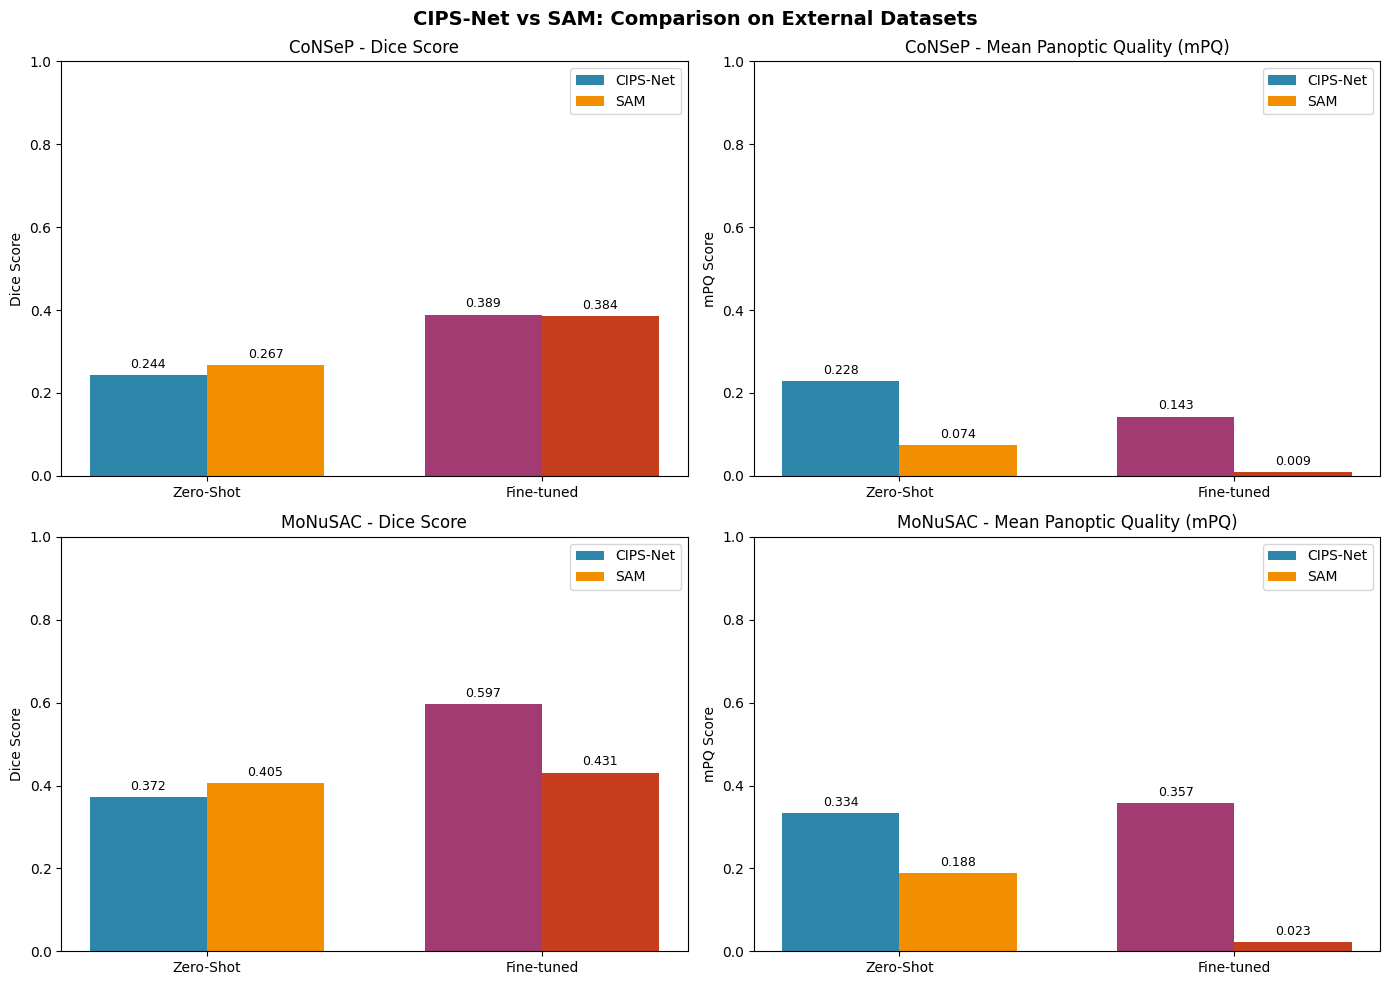

✓ Visualization saved to results/finetuned_models/cipsnet_vs_sam_comparison.png


In [18]:
# Cell: Visualization - CIPS-Net vs SAM Comparison

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('CIPS-Net vs SAM: Comparison on External Datasets', fontsize=14, fontweight='bold')

# Color scheme
colors = {'CIPS-Net': ['#2E86AB', '#A23B72'], 'SAM': ['#F18F01', '#C73E1D']}  # [Zero-Shot, Fine-tuned]

# --- CoNSeP Dice ---
ax1 = axes[0, 0]
datasets = ['Zero-Shot', 'Fine-tuned']
x = np.arange(len(datasets))
width = 0.35

cipsnet_consep_dice = [
    all_results.get('zeroshot_CoNSeP', {}).get('overall', {}).get('Dice', 0),
    all_results.get('finetuned_CoNSeP', {}).get('overall', {}).get('dice', 0)
]
sam_consep_dice = [
    all_results.get('SAM_zeroshot_CoNSeP', {}).get('overall', {}).get('Dice', 0),
    all_results.get('SAM_finetuned_CoNSeP', {}).get('overall', {}).get('dice', 0)
]

bars1 = ax1.bar(x - width/2, cipsnet_consep_dice, width, label='CIPS-Net', color=['#2E86AB', '#A23B72'])
bars2 = ax1.bar(x + width/2, sam_consep_dice, width, label='SAM', color=['#F18F01', '#C73E1D'])

ax1.set_ylabel('Dice Score')
ax1.set_title('CoNSeP - Dice Score')
ax1.set_xticks(x)
ax1.set_xticklabels(datasets)
ax1.legend()
ax1.set_ylim(0, 1)
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

# --- CoNSeP mPQ ---
ax2 = axes[0, 1]
cipsnet_consep_mpq = [
    all_results.get('zeroshot_CoNSeP', {}).get('mPQ', 0),
    all_results.get('finetuned_CoNSeP', {}).get('mPQ', 0)
]
sam_consep_mpq = [
    all_results.get('SAM_zeroshot_CoNSeP', {}).get('mPQ', 0),
    all_results.get('SAM_finetuned_CoNSeP', {}).get('mPQ', 0)
]

bars1 = ax2.bar(x - width/2, cipsnet_consep_mpq, width, label='CIPS-Net', color=['#2E86AB', '#A23B72'])
bars2 = ax2.bar(x + width/2, sam_consep_mpq, width, label='SAM', color=['#F18F01', '#C73E1D'])

ax2.set_ylabel('mPQ Score')
ax2.set_title('CoNSeP - Mean Panoptic Quality (mPQ)')
ax2.set_xticks(x)
ax2.set_xticklabels(datasets)
ax2.legend()
ax2.set_ylim(0, 1)
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

# --- MoNuSAC Dice ---
ax3 = axes[1, 0]
cipsnet_monusac_dice = [
    all_results.get('zeroshot_MoNuSAC', {}).get('overall', {}).get('Dice', 0),
    all_results.get('finetuned_MoNuSAC', {}).get('overall', {}).get('dice', 0)
]
sam_monusac_dice = [
    all_results.get('SAM_zeroshot_MoNuSAC', {}).get('overall', {}).get('Dice', 0),
    all_results.get('SAM_finetuned_MoNuSAC', {}).get('overall', {}).get('dice', 0)
]

bars1 = ax3.bar(x - width/2, cipsnet_monusac_dice, width, label='CIPS-Net', color=['#2E86AB', '#A23B72'])
bars2 = ax3.bar(x + width/2, sam_monusac_dice, width, label='SAM', color=['#F18F01', '#C73E1D'])

ax3.set_ylabel('Dice Score')
ax3.set_title('MoNuSAC - Dice Score')
ax3.set_xticks(x)
ax3.set_xticklabels(datasets)
ax3.legend()
ax3.set_ylim(0, 1)
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

# --- MoNuSAC mPQ ---
ax4 = axes[1, 1]
cipsnet_monusac_mpq = [
    all_results.get('zeroshot_MoNuSAC', {}).get('mPQ', 0),
    all_results.get('finetuned_MoNuSAC', {}).get('mPQ', 0)
]
sam_monusac_mpq = [
    all_results.get('SAM_zeroshot_MoNuSAC', {}).get('mPQ', 0),
    all_results.get('SAM_finetuned_MoNuSAC', {}).get('mPQ', 0)
]

bars1 = ax4.bar(x - width/2, cipsnet_monusac_mpq, width, label='CIPS-Net', color=['#2E86AB', '#A23B72'])
bars2 = ax4.bar(x + width/2, sam_monusac_mpq, width, label='SAM', color=['#F18F01', '#C73E1D'])

ax4.set_ylabel('mPQ Score')
ax4.set_title('MoNuSAC - Mean Panoptic Quality (mPQ)')
ax4.set_xticks(x)
ax4.set_xticklabels(datasets)
ax4.legend()
ax4.set_ylim(0, 1)
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig("results/finetuned_models/cipsnet_vs_sam_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Visualization saved to results/finetuned_models/cipsnet_vs_sam_comparison.png")

In [19]:
# Cell: Save Final Results Summary

final_results_summary = {
    'experiment_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'models_compared': ['CIPS-Net', 'SAM (ViT-B)'],
    'datasets': ['CoNSeP', 'MoNuSAC'],
    'experiments': ['Zero-Shot', 'Fine-tuned'],
    'all_results': all_results
}

# Save to JSON
with open("results/finetuned_models/cipsnet_vs_sam_all_results.json", 'w') as f:
    # Convert numpy types for JSON serialization
    def convert_types(obj):
        if isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, dict):
            return {k: convert_types(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [convert_types(item) for item in obj]
        return obj
    
    json.dump(convert_types(final_results_summary), f, indent=2)

print("\n" + "=" * 80)
print("FINAL SUMMARY: CIPS-Net vs SAM")
print("=" * 80)

print("\n📊 All Results Keys:", list(all_results.keys()))

print("\n" + "-" * 60)
print("Key Findings:")
print("-" * 60)

# Print key comparisons if available
for dataset in ['CoNSeP', 'MoNuSAC']:
    print(f"\n{dataset}:")
    
    zs_cips = all_results.get(f'zeroshot_{dataset}', {})
    ft_cips = all_results.get(f'finetuned_{dataset}', {})
    zs_sam = all_results.get(f'SAM_zeroshot_{dataset}', {})
    ft_sam = all_results.get(f'SAM_finetuned_{dataset}', {})
    
    if zs_cips and zs_sam:
        zs_cips_dice = zs_cips.get('overall', {}).get('Dice', 0)
        zs_sam_dice = zs_sam.get('overall', {}).get('Dice', 0)
        winner = "CIPS-Net" if zs_cips_dice > zs_sam_dice else "SAM"
        print(f"  Zero-Shot Dice: CIPS-Net={zs_cips_dice:.4f}, SAM={zs_sam_dice:.4f} → Winner: {winner}")
    
    if ft_cips and ft_sam:
        ft_cips_dice = ft_cips.get('overall', {}).get('dice', 0)
        ft_sam_dice = ft_sam.get('overall', {}).get('dice', 0)
        winner = "CIPS-Net" if ft_cips_dice > ft_sam_dice else "SAM"
        print(f"  Fine-tuned Dice: CIPS-Net={ft_cips_dice:.4f}, SAM={ft_sam_dice:.4f} → Winner: {winner}")

print(f"\n✓ All results saved to results/finetuned_models/cipsnet_vs_sam_all_results.json")
print("\n" + "=" * 80)
print("Experiment Complete!")
print("=" * 80)


FINAL SUMMARY: CIPS-Net vs SAM

📊 All Results Keys: ['SAM_finetuned_CoNSeP', 'SAM_finetuned_MoNuSAC', 'zeroshot_CoNSeP', 'zeroshot_MoNuSAC', 'finetuned_CoNSeP', 'finetuned_MoNuSAC', 'SAM_zeroshot_CoNSeP', 'SAM_zeroshot_MoNuSAC']

------------------------------------------------------------
Key Findings:
------------------------------------------------------------

CoNSeP:
  Zero-Shot Dice: CIPS-Net=0.2437, SAM=0.2670 → Winner: SAM
  Fine-tuned Dice: CIPS-Net=0.3891, SAM=0.3844 → Winner: CIPS-Net

MoNuSAC:
  Zero-Shot Dice: CIPS-Net=0.3718, SAM=0.4052 → Winner: SAM
  Fine-tuned Dice: CIPS-Net=0.5966, SAM=0.4313 → Winner: CIPS-Net

✓ All results saved to results/finetuned_models/cipsnet_vs_sam_all_results.json

Experiment Complete!


In [22]:
# Cell 45: Model Parameters Verification
# Calculate actual parameters for both SAM and CIPS-Net

print("=" * 60)
print("MODEL PARAMETERS VERIFICATION")
print("=" * 60)

# ===================== SAM Parameters =====================
print("\n1. SAM (ViT-B) Parameters:")
print("-" * 40)

# SAM is already loaded as 'sam' variable
sam_total_params = sum(p.numel() for p in sam.parameters())
sam_trainable_params = sum(p.numel() for p in sam.parameters() if p.requires_grad)

# Component breakdown
sam_image_encoder_params = sum(p.numel() for p in sam.image_encoder.parameters())
sam_prompt_encoder_params = sum(p.numel() for p in sam.prompt_encoder.parameters())
sam_mask_decoder_params = sum(p.numel() for p in sam.mask_decoder.parameters())

print(f"  Total Parameters: {sam_total_params:,} ({sam_total_params/1e6:.2f}M)")
print(f"  Trainable Parameters: {sam_trainable_params:,}")
print(f"  Component Breakdown:")
print(f"    - Image Encoder: {sam_image_encoder_params:,} ({sam_image_encoder_params/1e6:.2f}M)")
print(f"    - Prompt Encoder: {sam_prompt_encoder_params:,} ({sam_prompt_encoder_params/1e6:.2f}M)")
print(f"    - Mask Decoder: {sam_mask_decoder_params:,} ({sam_mask_decoder_params/1e6:.2f}M)")

# ===================== CIPS-Net Parameters =====================
print("\n2. CIPS-Net Parameters:")
print("-" * 40)

# Load CIPS-Net config
config_path = f"{EXPERIMENT_DIR}/config.yaml"
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Initialize CIPS-Net model with CORRECT parameter names (from cell 5)
cipsnet_model = CIPSNet(
    num_classes=config['num_classes'],
    img_encoder_name=config['img_encoder'],
    text_encoder_name=config['text_encoder'],
    embed_dim=config['embed_dim'],
    img_size=config['img_size']
)

cipsnet_total_params = sum(p.numel() for p in cipsnet_model.parameters())
cipsnet_trainable_params = sum(p.numel() for p in cipsnet_model.parameters() if p.requires_grad)

# Component breakdown - using correct attribute names from cips_net.py
cipsnet_img_encoder_params = sum(p.numel() for p in cipsnet_model.image_encoder.parameters())
cipsnet_text_encoder_params = sum(p.numel() for p in cipsnet_model.text_encoder.parameters())
cipsnet_decoder_params = sum(p.numel() for p in cipsnet_model.decoder.parameters())
cipsnet_grounding_params = sum(p.numel() for p in cipsnet_model.grounding_module.parameters())

print(f"  Total Parameters: {cipsnet_total_params:,} ({cipsnet_total_params/1e6:.2f}M)")
print(f"  Trainable Parameters: {cipsnet_trainable_params:,}")
print(f"  Component Breakdown:")
print(f"    - Image Encoder (ViT-B/16): {cipsnet_img_encoder_params:,} ({cipsnet_img_encoder_params/1e6:.2f}M)")
print(f"    - Text Encoder (DistilBERT): {cipsnet_text_encoder_params:,} ({cipsnet_text_encoder_params/1e6:.2f}M)")
print(f"    - Decoder: {cipsnet_decoder_params:,} ({cipsnet_decoder_params/1e6:.2f}M)")
print(f"    - Grounding Module: {cipsnet_grounding_params:,} ({cipsnet_grounding_params/1e6:.2f}M)")

# ===================== Summary Comparison =====================
print("\n" + "=" * 60)
print("PARAMETERS SUMMARY")
print("=" * 60)
print(f"  SAM (ViT-B):    {sam_total_params/1e6:.2f}M parameters")
print(f"  CIPS-Net:       {cipsnet_total_params/1e6:.2f}M parameters")
print(f"  Difference:     {abs(sam_total_params - cipsnet_total_params)/1e6:.2f}M")
if sam_total_params > cipsnet_total_params:
    print(f"  Ratio:          SAM is {sam_total_params/cipsnet_total_params:.2f}x larger than CIPS-Net")
else:
    print(f"  Ratio:          CIPS-Net is {cipsnet_total_params/sam_total_params:.2f}x larger than SAM")
print("=" * 60)

MODEL PARAMETERS VERIFICATION

1. SAM (ViT-B) Parameters:
----------------------------------------
  Total Parameters: 93,735,472 (93.74M)
  Trainable Parameters: 93,735,472
  Component Breakdown:
    - Image Encoder: 89,670,912 (89.67M)
    - Prompt Encoder: 6,220 (0.01M)
    - Mask Decoder: 4,058,340 (4.06M)

2. CIPS-Net Parameters:
----------------------------------------


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Total Parameters: 120,601,349 (120.60M)
  Trainable Parameters: 120,601,349
  Component Breakdown:
    - Image Encoder (ViT-B/16): 22,110,720 (22.11M)
    - Text Encoder (DistilBERT): 67,547,136 (67.55M)
    - Decoder: 3,738,629 (3.74M)
    - Grounding Module: 27,204,864 (27.20M)

PARAMETERS SUMMARY
  SAM (ViT-B):    93.74M parameters
  CIPS-Net:       120.60M parameters
  Difference:     26.87M
  Ratio:          CIPS-Net is 1.29x larger than SAM


✓ Graph saved to results/cipsnet_pannuke_classwise_comparison.png


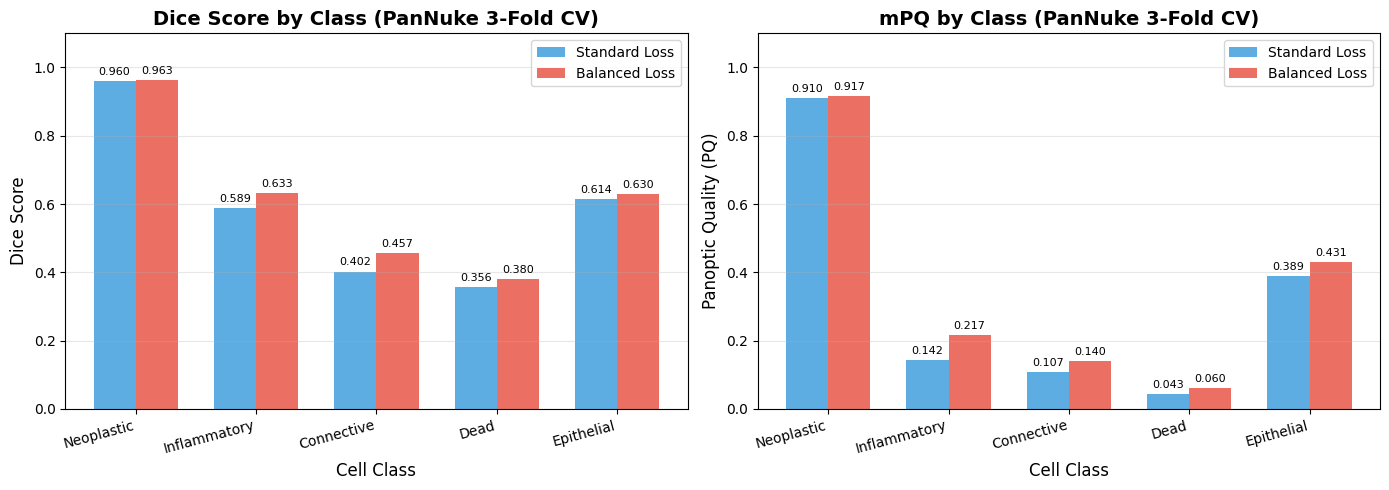

In [25]:
# Cell 46: Create Class-wise Comparison Graph for CIPS-Net on PanNuke
# Comparing Standard vs Balanced Sampling (ViT-B/16 + DistilBERT)

import matplotlib.pyplot as plt
import numpy as np

# Class names
classes = ['Neoplastic', 'Inflammatory', 'Connective', 'Dead', 'Epithelial']

# Standard Sampling Results (ViT-B/16 + DistilBERT)
dice_standard = [0.960, 0.589, 0.402, 0.356, 0.614]
pq_standard = [0.910, 0.142, 0.107, 0.043, 0.389]

# Balanced Sampling Results (ViT-B/16 + DistilBERT)
dice_balanced = [0.963, 0.633, 0.457, 0.380, 0.630]
pq_balanced = [0.917, 0.217, 0.140, 0.060, 0.431]

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

x = np.arange(len(classes))
width = 0.35

# Plot 1: Dice Score
bars1 = ax1.bar(x - width/2, dice_standard, width, label='Standard Loss', color='#3498db', alpha=0.8)
bars2 = ax1.bar(x + width/2, dice_balanced, width, label='Balanced Loss', color='#e74c3c', alpha=0.8)

ax1.set_xlabel('Cell Class', fontsize=12)
ax1.set_ylabel('Dice Score', fontsize=12)
ax1.set_title('Dice Score by Class (PanNuke 3-Fold CV)', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(classes, rotation=15, ha='right')
ax1.legend(loc='upper right')
ax1.set_ylim(0, 1.1)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    ax1.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

# Plot 2: PQ Score
bars3 = ax2.bar(x - width/2, pq_standard, width, label='Standard Loss', color='#3498db', alpha=0.8)
bars4 = ax2.bar(x + width/2, pq_balanced, width, label='Balanced Loss', color='#e74c3c', alpha=0.8)

ax2.set_xlabel('Cell Class', fontsize=12)
ax2.set_ylabel('Panoptic Quality (PQ)', fontsize=12)
ax2.set_title('mPQ by Class (PanNuke 3-Fold CV)', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(classes, rotation=15, ha='right')
ax2.legend(loc='upper right')
ax2.set_ylim(0, 1.1)
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars3:
    height = bar.get_height()
    ax2.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
for bar in bars4:
    height = bar.get_height()
    ax2.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

plt.tight_layout()

# Save the figure for LaTeX report
save_path = 'results/cipsnet_pannuke_classwise_comparison.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Graph saved to {save_path}")

plt.show()